In [2]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [3]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import TemporalFusionTransformer, Baseline, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE
from pytorch_forecasting.data.encoders import NaNLabelEncoder, GroupNormalizer
import pytorch_forecasting

# imports for training
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from lightning.pytorch.tuner import Tuner
import traceback

In [4]:
# Load data
data = pd.read_csv('/Users/zhezhengren/Desktop/NeuroPrior_AI/Model_Competion/EEG/Data_Processing/Data_Epoch_Range/Data_Epoch.csv')

# Create a list of channel names
channel_names = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'CZ', 'C4', 
                 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'PZ', 'P4', 'P8', 'PO9', 'O1', 'OZ', 
                 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 
                 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 
                 'PO3', 'POZ', 'PO4', 'PO8']

if 'Unnamed: 0.1' in data.columns:
    data = data.drop(columns=['Unnamed: 0.1'])

if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

print(data.columns)

non_numeric_columns = data.select_dtypes(include=['object']).columns
print(non_numeric_columns)

data['FileName'] = data['FileName'].astype(str)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Event Name'] = le.fit_transform(data['Event Name'].astype(str)).astype(float)

for channel in channel_names:
    data[channel] = data[channel].astype(float)

Index(['FileName', 'Event Name', 'Time_Point', 'FP1', 'FP2', 'F7', 'F3', 'FZ',
       'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'CZ', 'C4', 'T8',
       'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'PZ', 'P4', 'P8',
       'PO9', 'O1', 'OZ', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1',
       'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2',
       'C6', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7',
       'PO3', 'POZ', 'PO4', 'PO8'],
      dtype='object')
Index(['FileName', 'Event Name'], dtype='object')


In [5]:
data.describe()

Event Name    Time_Point           FP1           FP2            F7  \
count  8.935034e+06  8.935034e+06  8.935034e+06  8.935034e+06  8.935034e+06   
mean   5.128407e+00  7.045445e+04 -3.115906e-07 -6.782022e-07  2.448467e-07   
std    1.666626e+00  4.155020e+04  5.320359e-05  6.908033e-05  2.793612e-05   
min    0.000000e+00  0.000000e+00 -1.168954e-03 -1.979760e-03 -5.560171e-04   
25%    6.000000e+00  3.490200e+04 -1.463787e-05 -1.450618e-05 -1.152337e-05   
50%    6.000000e+00  6.980400e+04 -2.277831e-06 -2.407344e-06 -1.257492e-07   
75%    6.000000e+00  1.047070e+05  1.021063e-05  9.823225e-06  1.128663e-05   
max    6.000000e+00  2.025340e+05  2.591308e-03  3.034607e-03  8.859959e-04   

                 F3            FZ            F4            F8           FC5  \
count  8.935034e+06  8.935034e+06  8.935034e+06  8.935034e+06  8.935034e+06   
mean   3.570915e-08 -1.229705e-08  8.840254e-09 -6.684581e-08  1.209507e-07   
std    1.776322e-05  1.249871e-05  1.618682e-05  2.725982e-05  2.250818e-05   
min   -4.956512e-04 -6.302431e-04 -3.024491e-04 -5.016216e-04 -6.428357e-04   
25%   -8.875036e-06 -6.148119e-06 -8.862103e-06 -1.182000e-05 -9.229579e-06   
50%   -2.079940e-07 -1.828231e-07 -2.127272e-07 -2.077187e-07  9.016666e-08   
75%    8.746018e-06  5.844003e-06  8.618712e-06  1.152293e-05  9.502170e-06   
max    2.211873e-04  1.084445e-04  2.879843e-04  5.806930e-04  6.281690e-04   

       ...           TP8            P5            P1            P2  \
count  ...  8.935034e+06  8.935034e+06  8.935034e+06  8.935034e+06   
mean   ...  1.953541e-07  4.961062e-08  5.771616e-08  5.716799e-08   
std    ...  2.849350e-05  1.988838e-05  1.877270e-05  1.972079e-05   
min    ... -3.070598e-03 -3.250377e-03 -3.331361e-03 -3.371235e-03   
25%    ... -1.133166e-05 -1.014979e-05 -9.605515e-06 -1.053415e-05   
50%    ...  2.309897e-07  1.795632e-07  2.227641e-07  2.365517e-07   
75%    ...  1.169710e-05  1.043431e-05  9.865727e-06  1.084657e-05   
max    ...  5.986769e-03  5.988817e-03  5.902428e-03  5.898313e-03   

                 P6           PO7           PO3           POZ           PO4  \
count  8.935034e+06  8.935034e+06  8.935034e+06  8.935034e+06  8.935034e+06   
mean   6.645271e-08  1.079891e-07  3.829087e-08  7.874696e-08  6.342398e-08   
std    2.155110e-05  2.278891e-05  2.050404e-05  2.035508e-05  2.245609e-05   
min   -3.236876e-03 -3.187349e-03 -3.151214e-03 -3.279416e-03 -3.394646e-03   
25%   -1.074530e-05 -1.159963e-05 -1.063858e-05 -1.046363e-05 -1.135537e-05   
50%    2.363301e-07  2.701590e-07  2.020529e-07  2.768342e-07  1.679846e-07   
75%    1.103895e-05  1.203252e-05  1.099449e-05  1.084293e-05  1.164706e-05   
max    5.993468e-03  6.006965e-03  6.043596e-03  6.008004e-03  5.937879e-03   

                PO8  
count  8.935034e+06  
mean   2.177812e-08  
std    2.840964e-05  
min   -3.167204e-03  
25%   -1.374761e-05  
50%    2.472149e-07  
75%    1.412200e-05  
max    6.023455e-03  

[8 rows x 66 columns]

In [6]:
max_prediction_length = 500
max_encoder_length = 1
training_cutoff = data["Time_Point"].max()*0.8

training = TimeSeriesDataSet(
    data[lambda x: x.Time_Point <= training_cutoff],
    time_idx="Time_Point",
    target="Event Name",
    group_ids=["FileName"],
    min_encoder_length=max(1,max_encoder_length // 2),  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Time_Point"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=channel_names,
    target_normalizer=GroupNormalizer(
        groups=["FileName"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet(
    data[lambda x: x.Time_Point >= training_cutoff],
    time_idx="Time_Point",
    target="Event Name",
    group_ids=["FileName"],
    min_encoder_length=max(1,max_encoder_length // 2),  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Time_Point"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=channel_names,
    target_normalizer=GroupNormalizer(
        groups=["FileName"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create dataloaders for model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

print(f"Training dataset length: {len(training)}")
print(f"Validation dataset length: {len(validation)}")

Training dataset length: 8904153
Validation dataset length: 65243


In [7]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100, # It should be 100
    accelerator="cpu",  # run on CPU, if on multiple GPUs, use strategy="ddp"
    #strategy="ddp",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    logger=TensorBoardLogger("lightning_logs")
)

# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.03,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 225.0k


Finding best initial lr: 100%|████████████████| 100/100 [08:26<00:00,  5.06s/it]
Learning rate set to 0.022675301300849538
Restoring states from the checkpoint path at /Users/zhezhengren/Desktop/NeuroPrior_AI/.lr_find_a1dd6df2-853b-4975-a710-fb7999aacb11.ckpt
Restored all states from the checkpoint at /Users/zhezhengren/Desktop/NeuroPrior_AI/.lr_find_a1dd6df2-853b-4975-a710-fb7999aacb11.ckpt


suggested learning rate: 0.022675301300849538


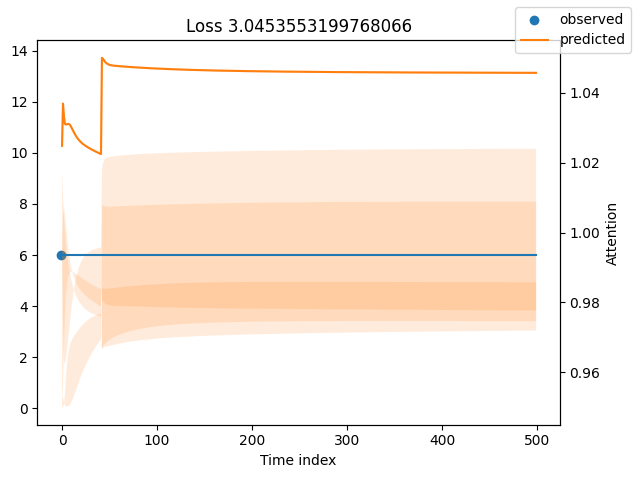

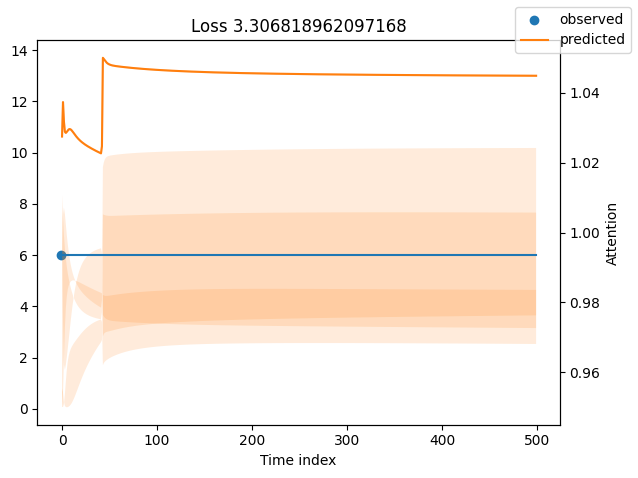

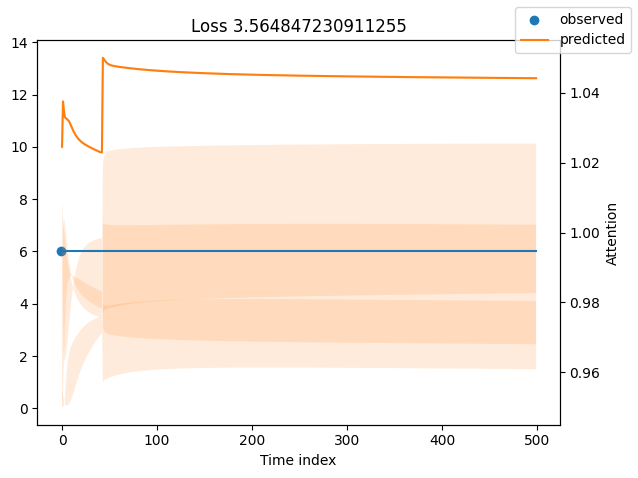

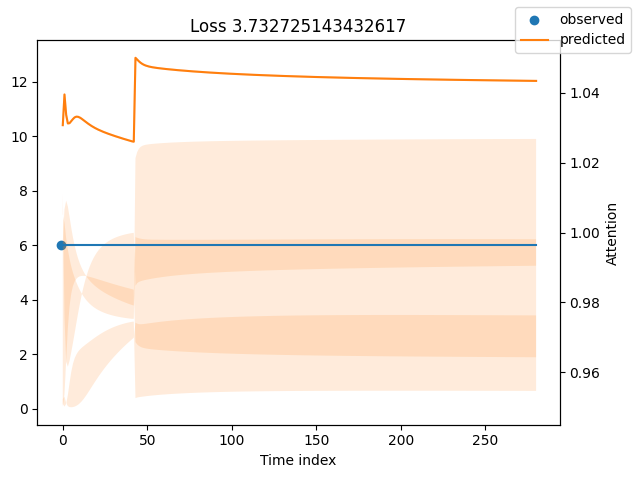

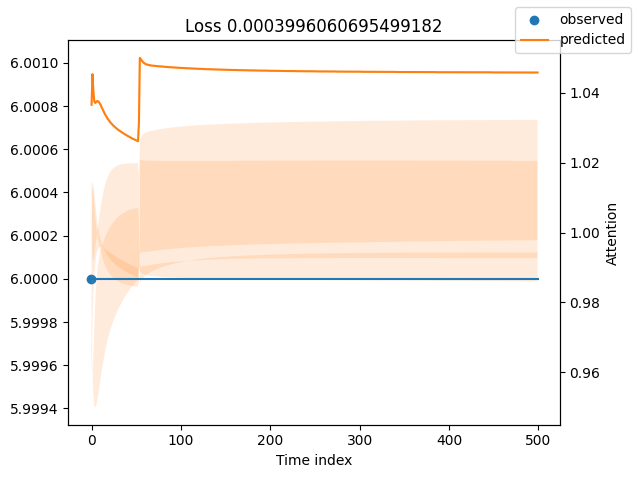

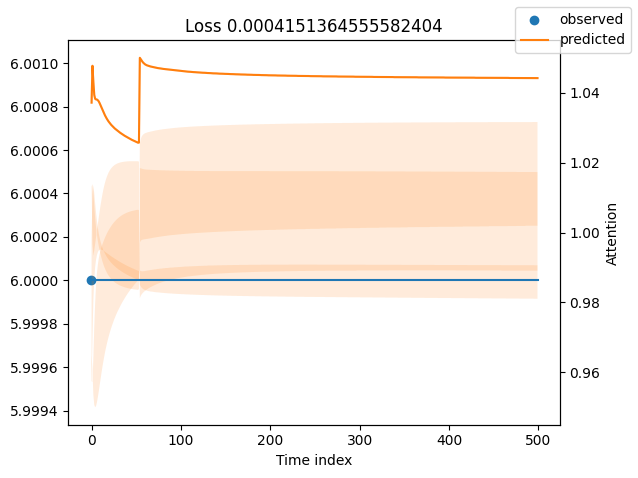

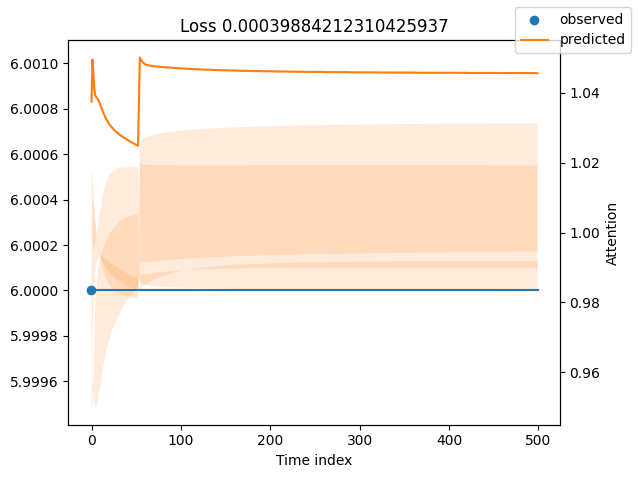

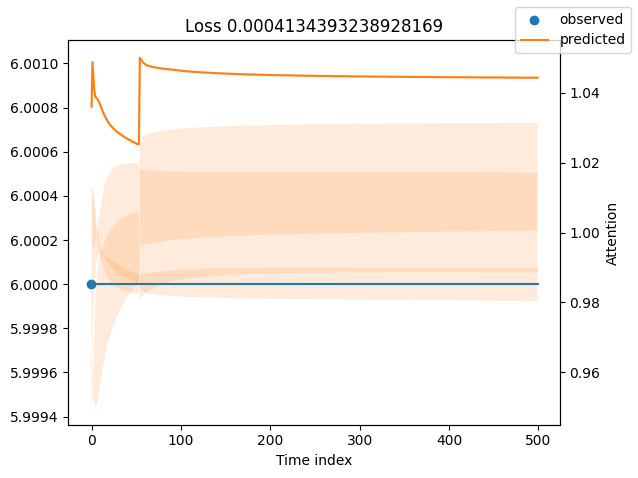

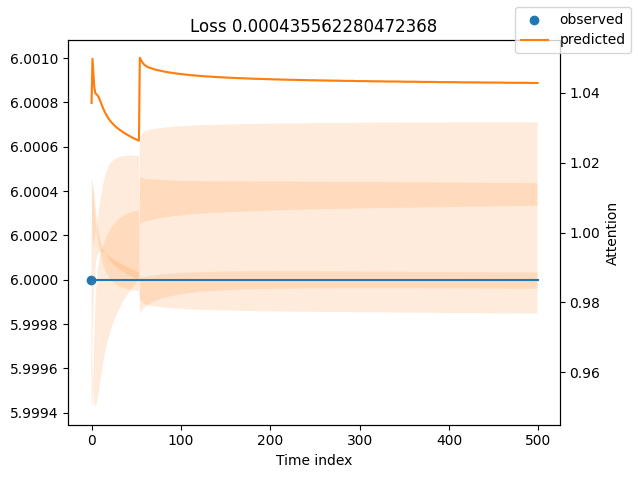

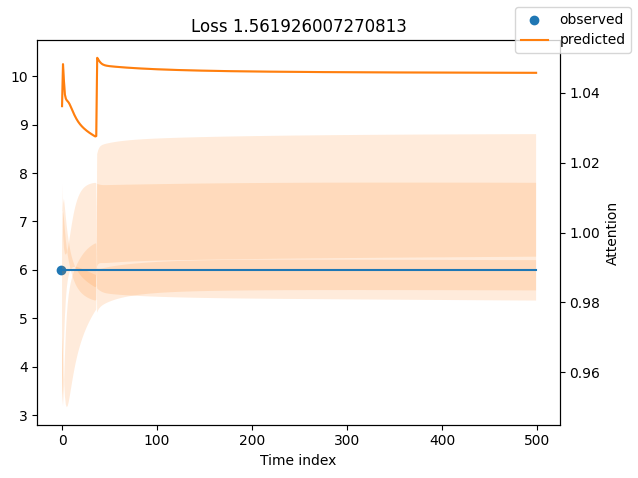

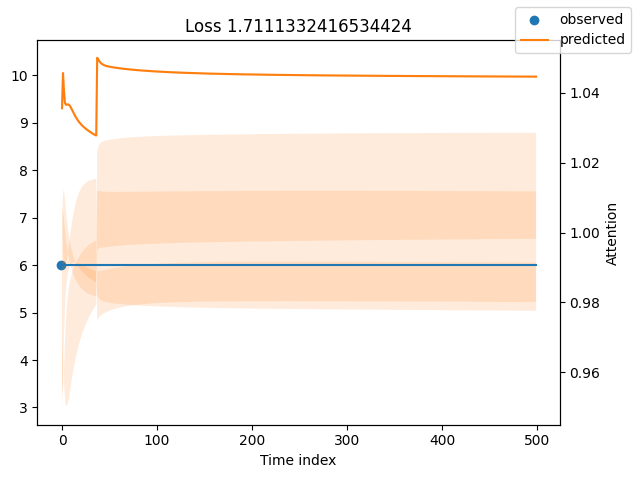

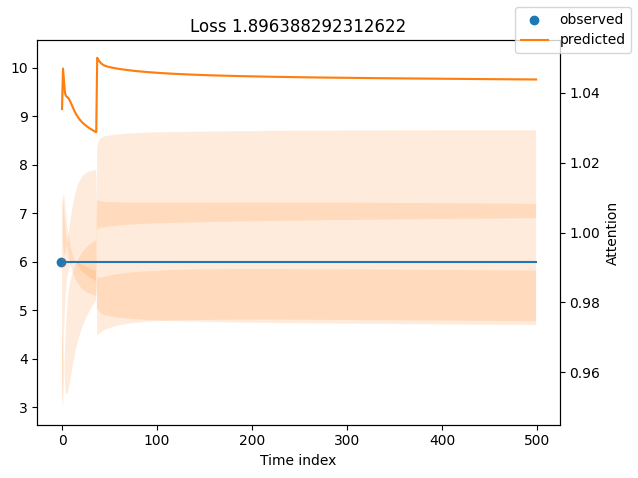

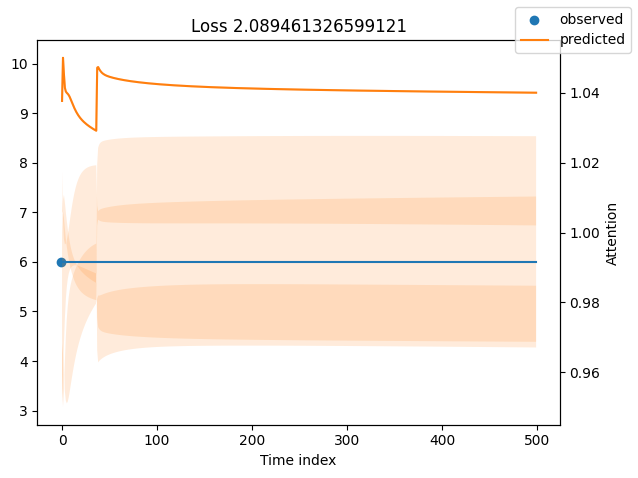

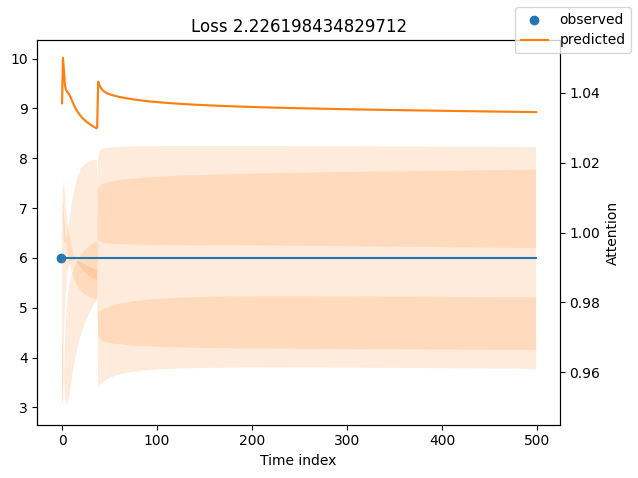

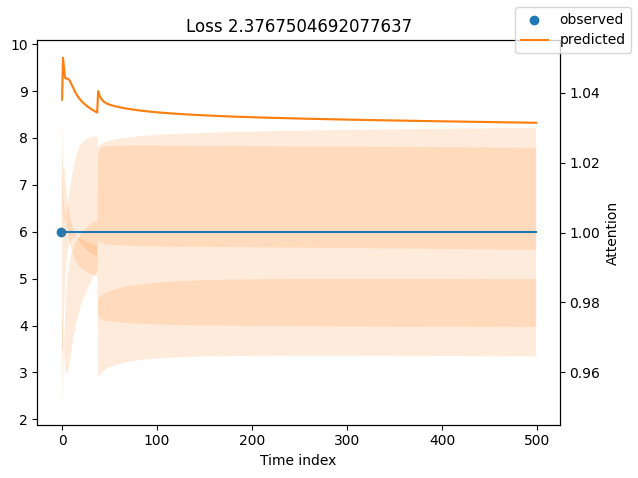

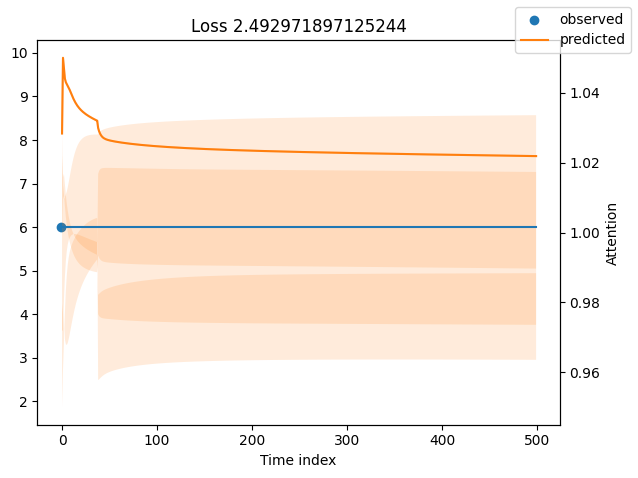

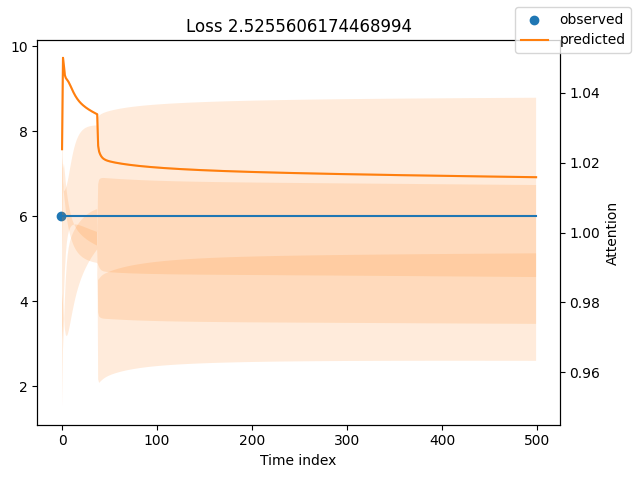

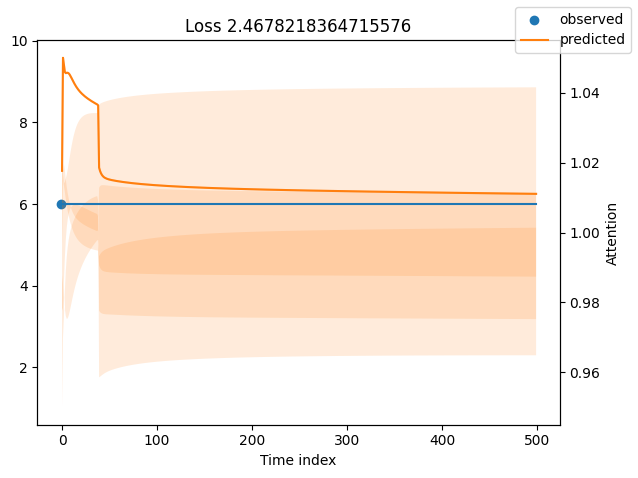

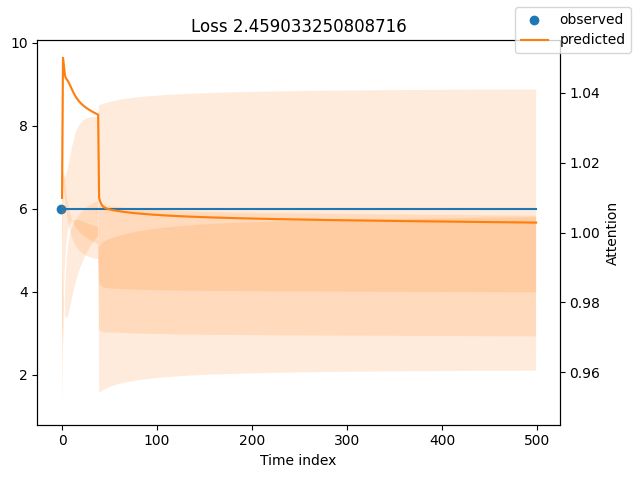

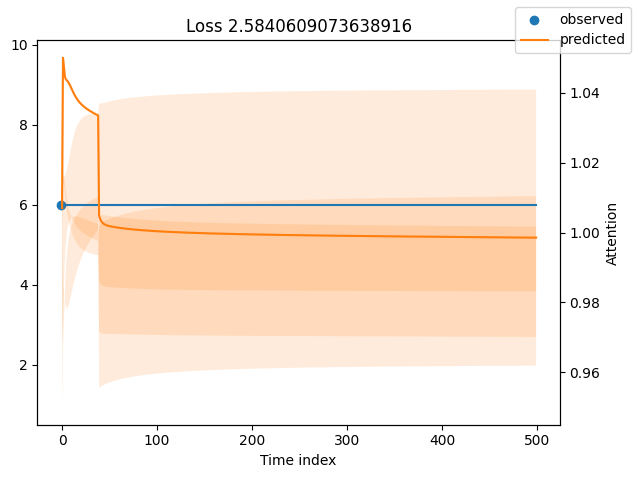

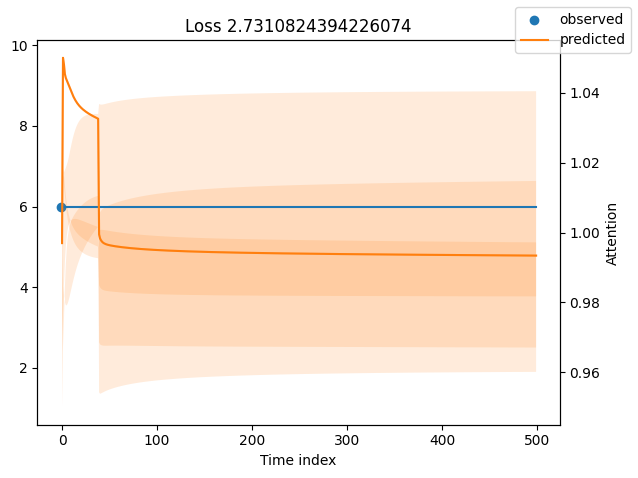

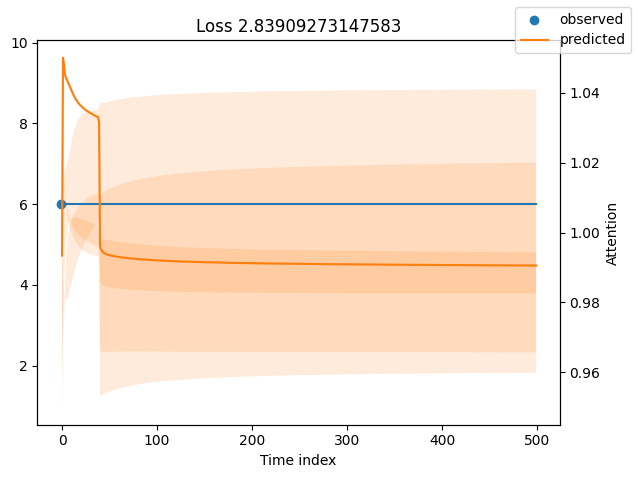

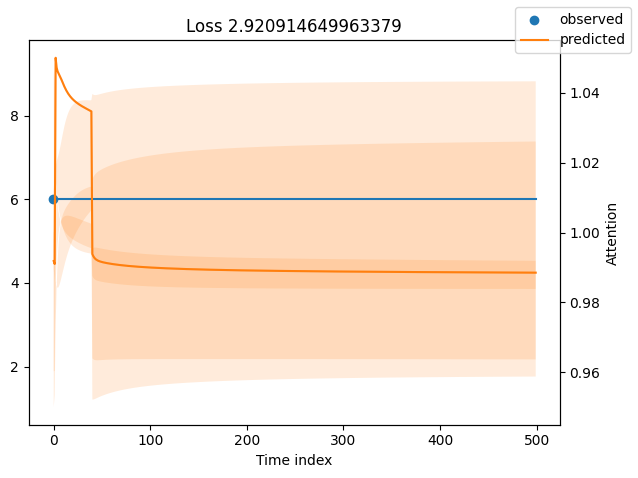

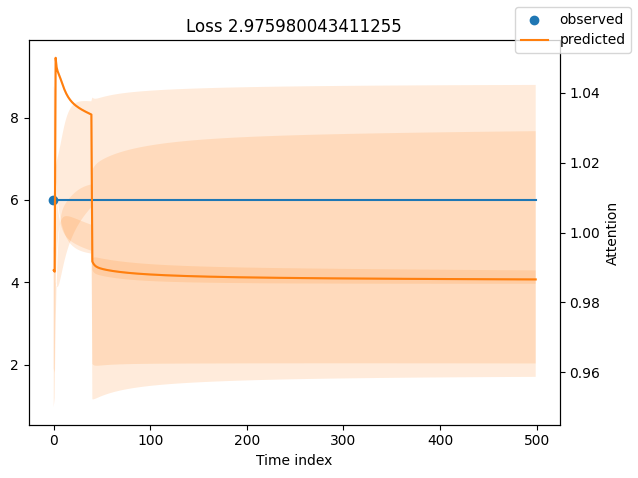

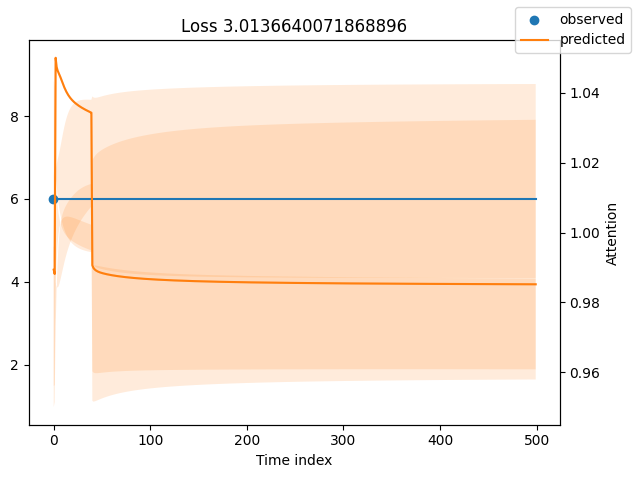

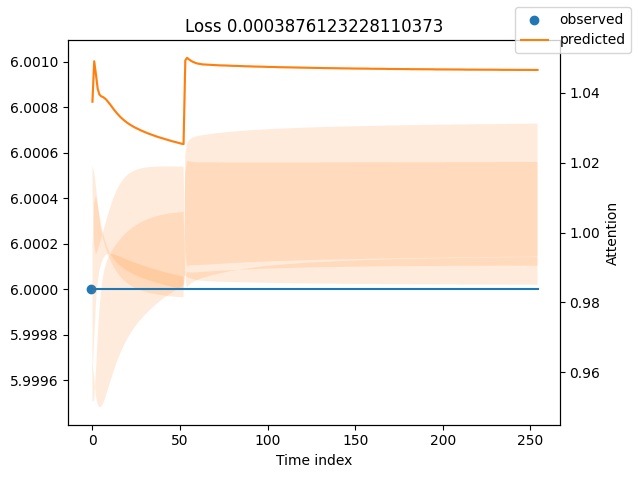

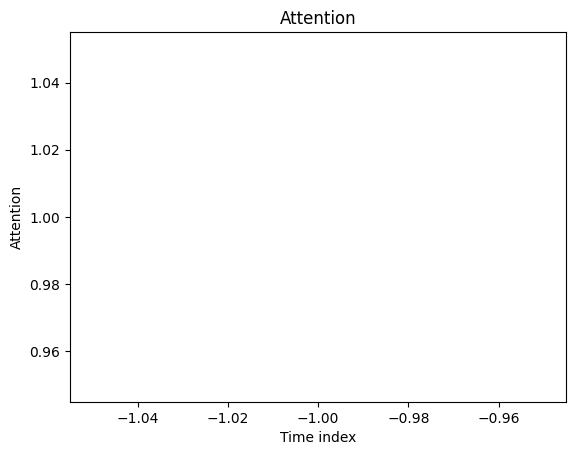

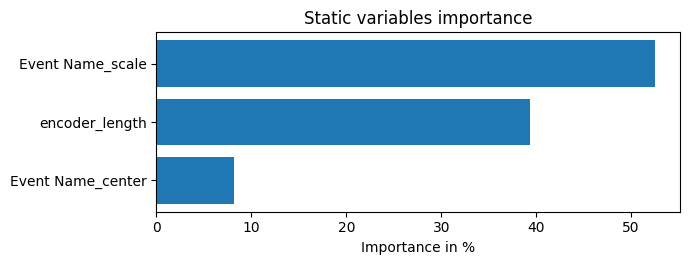

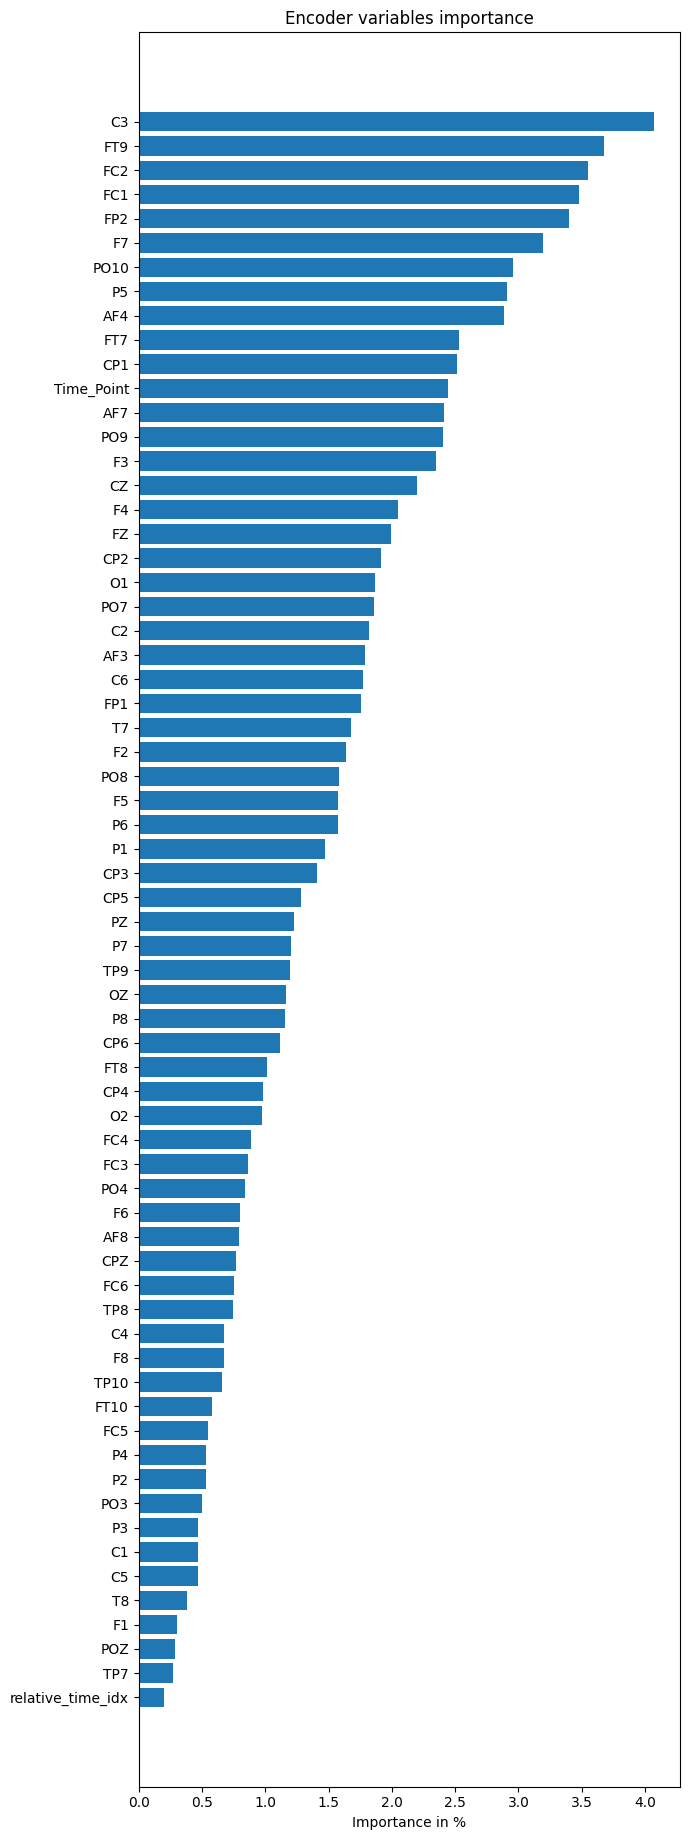

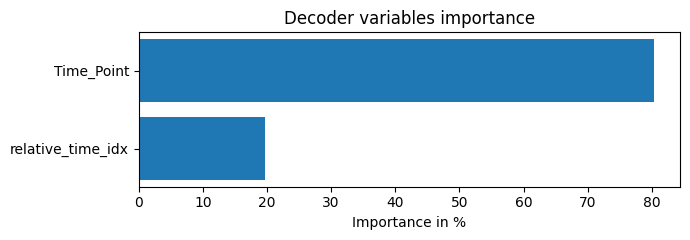

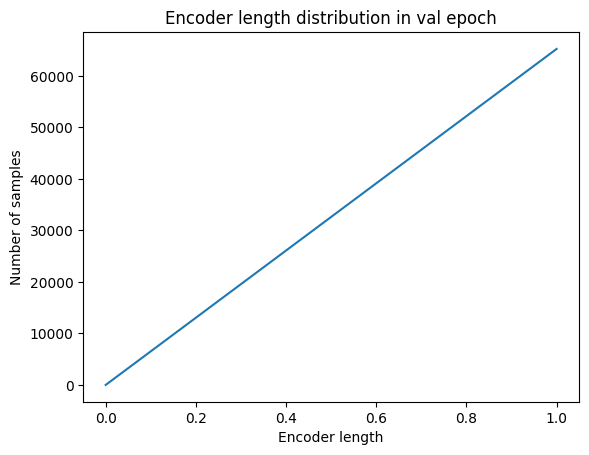

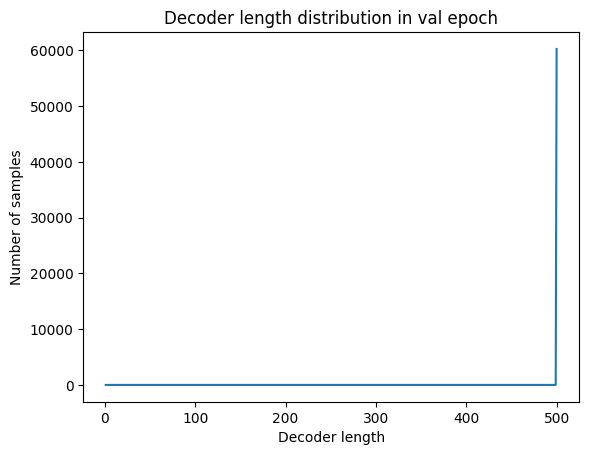

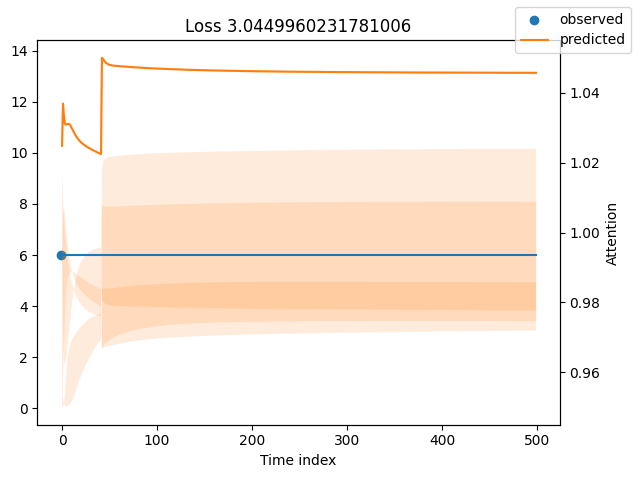

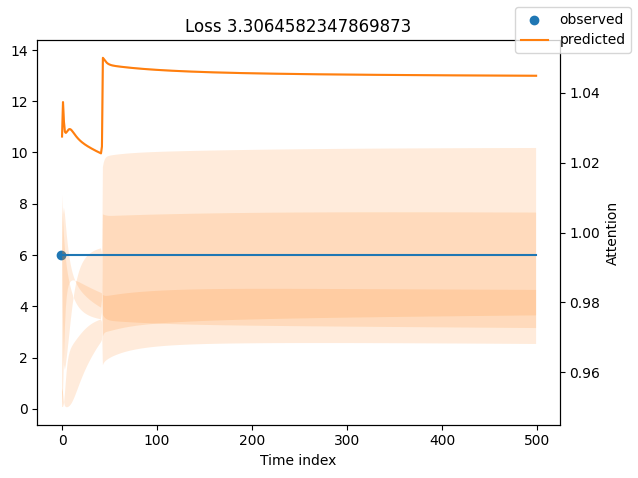

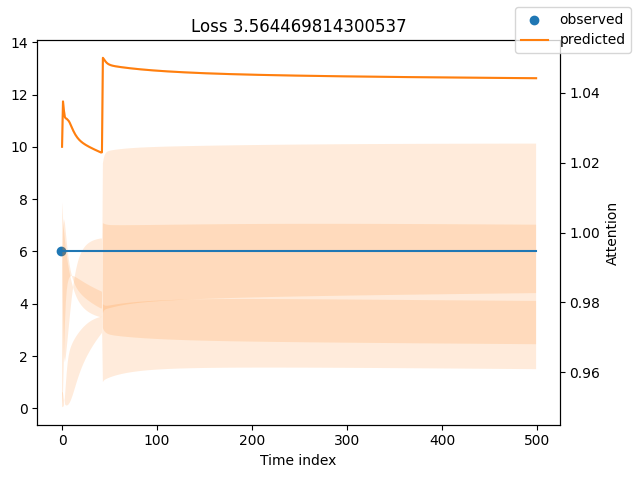

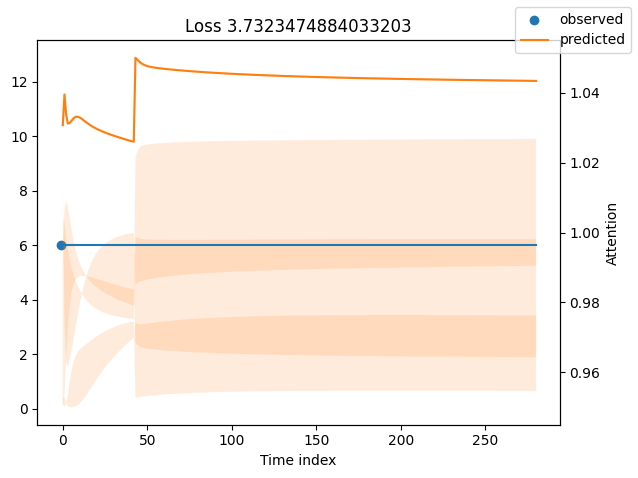

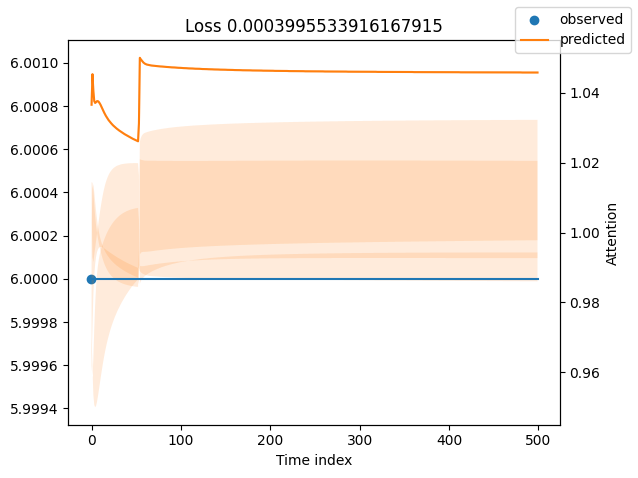

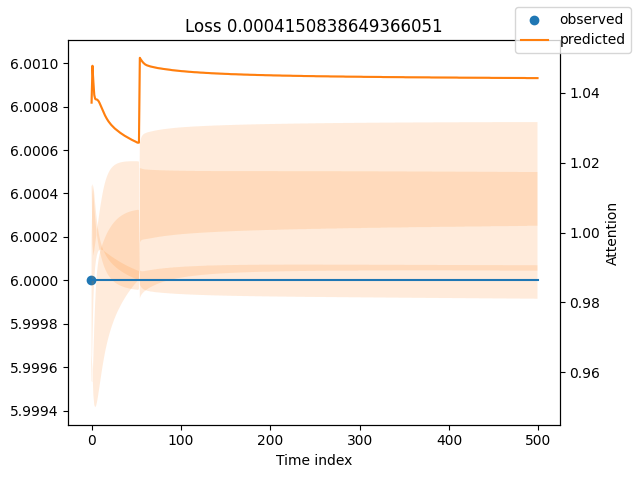

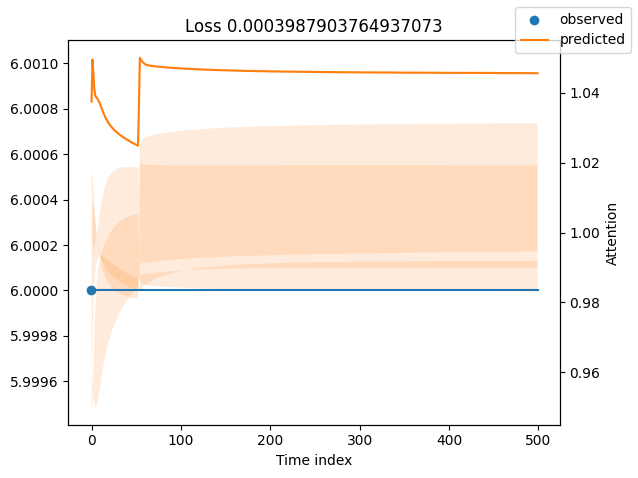

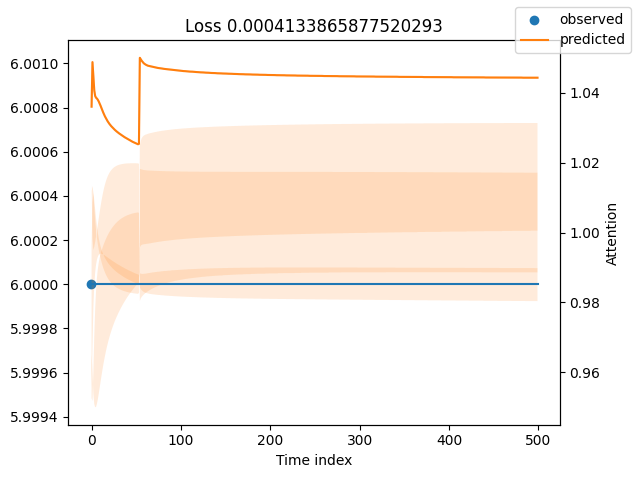

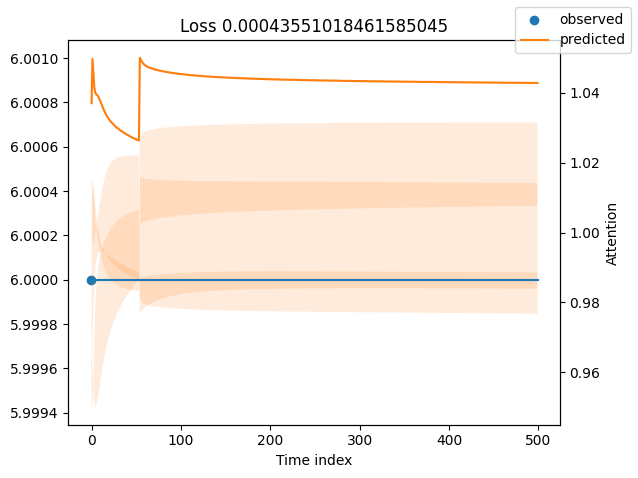

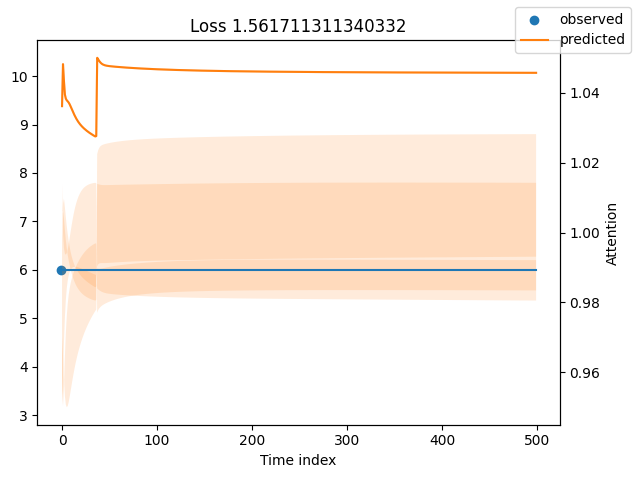

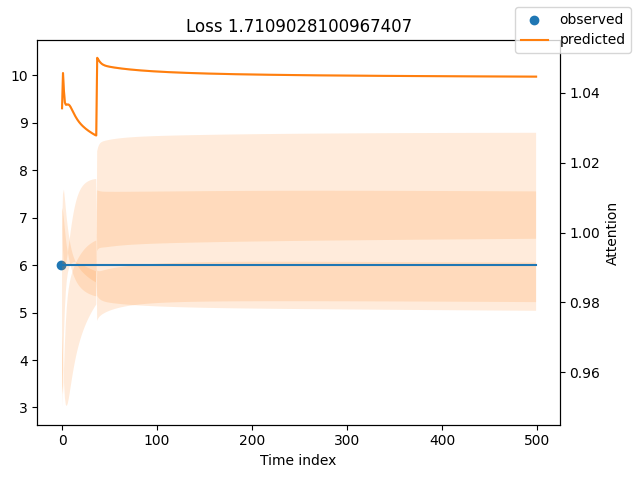

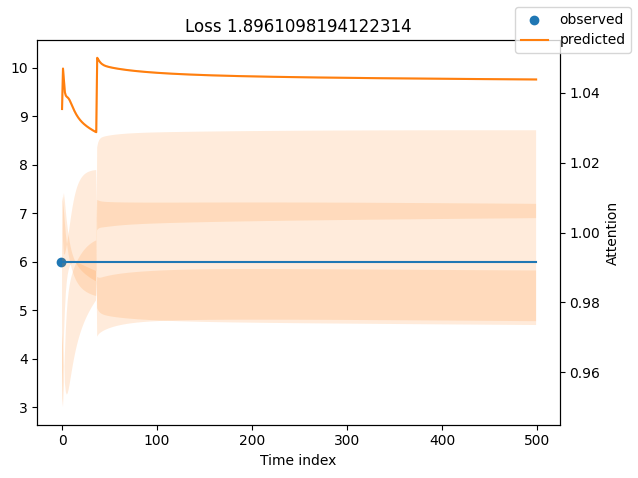

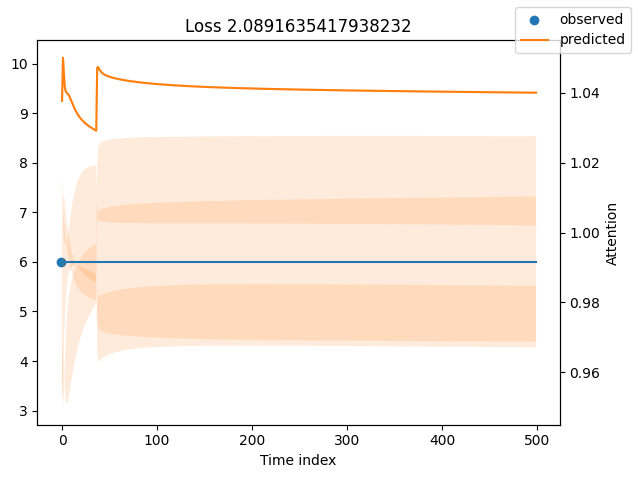

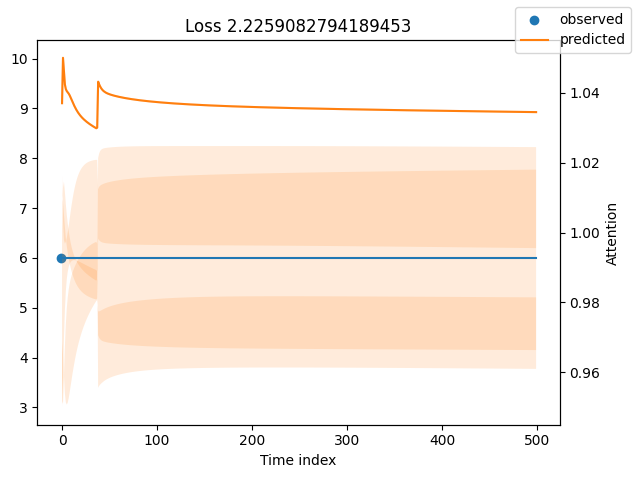

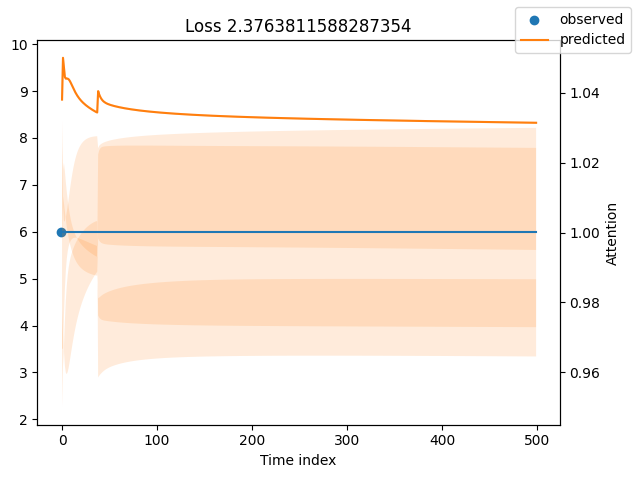

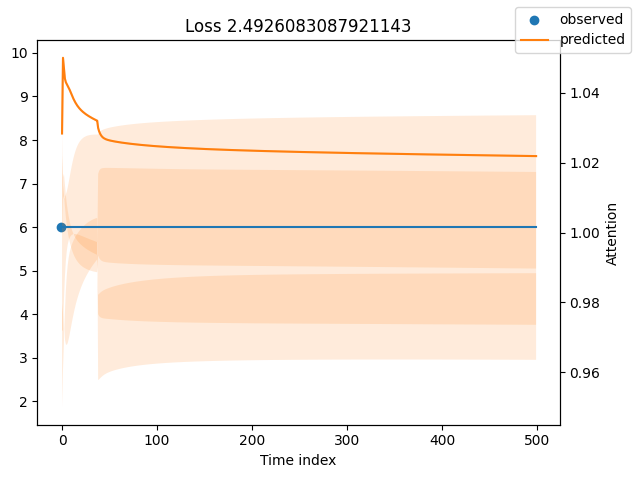

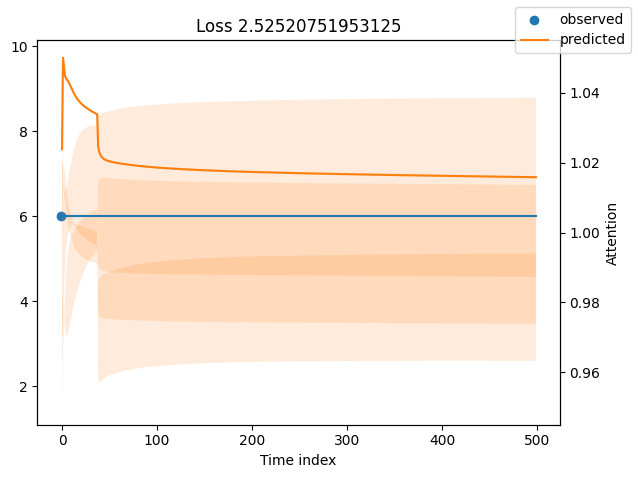

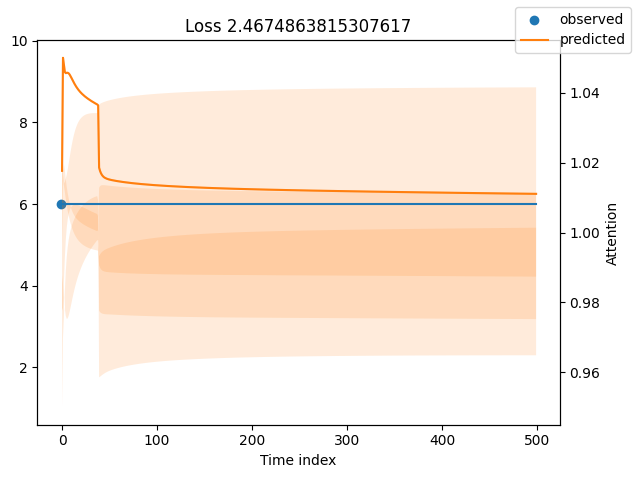

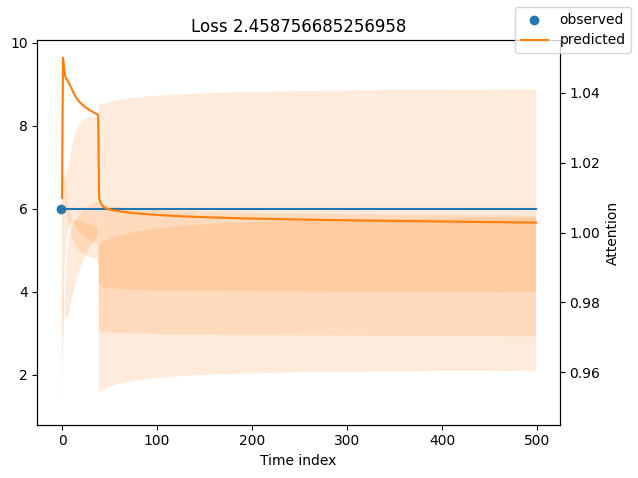

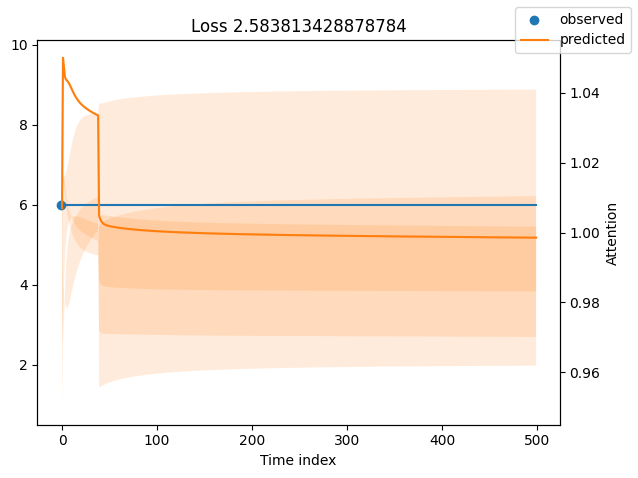

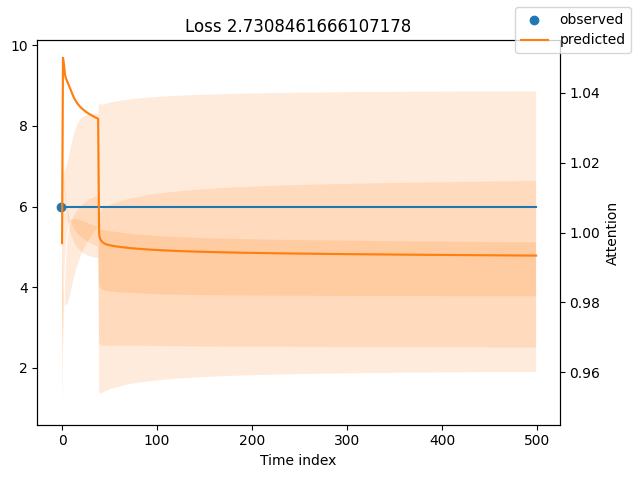

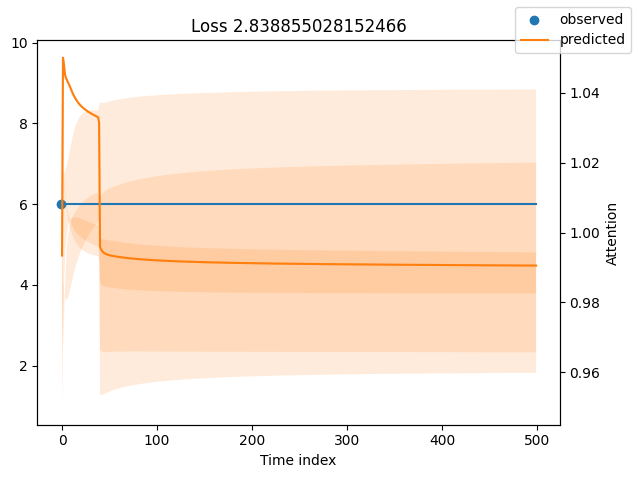

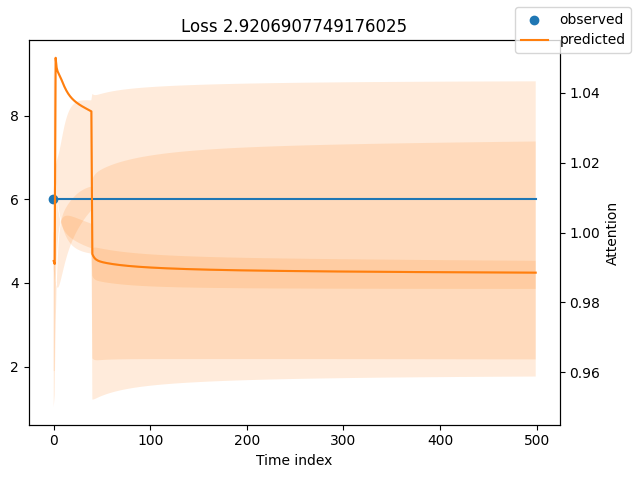

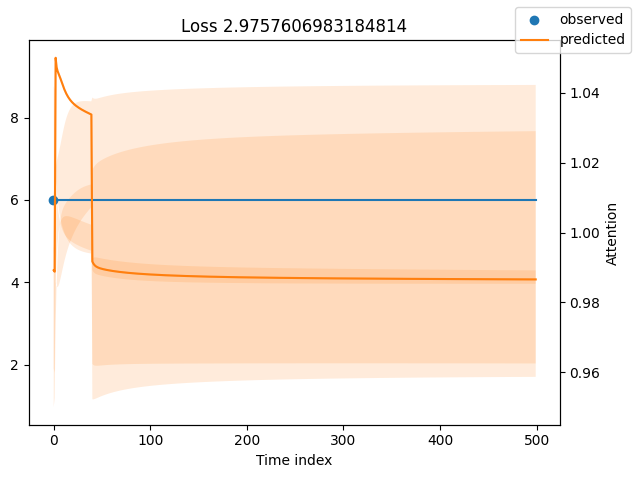

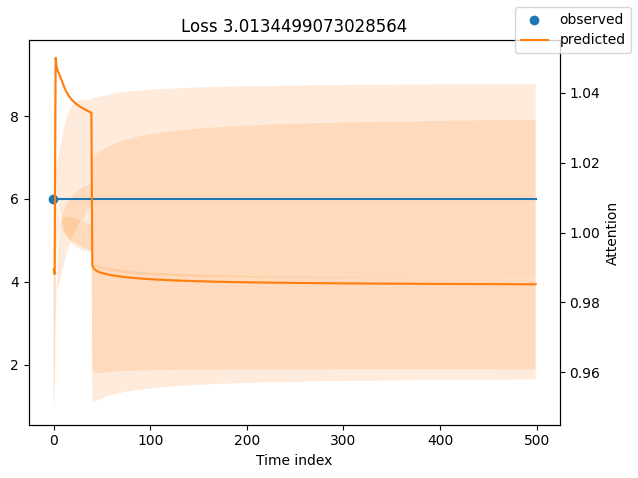

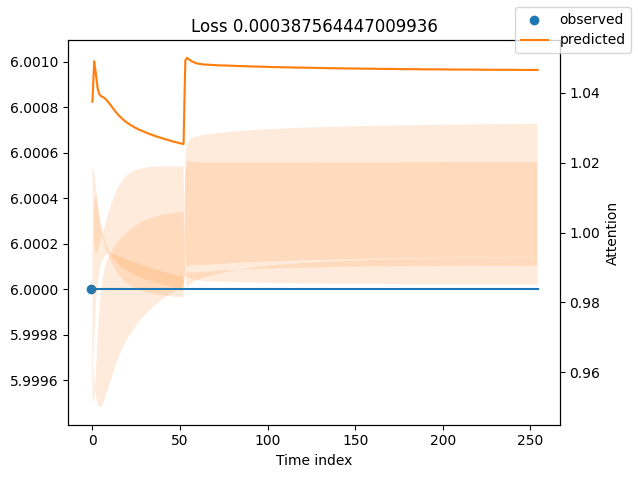

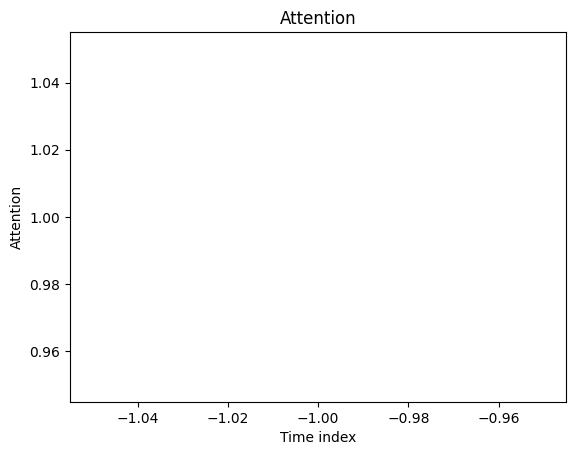

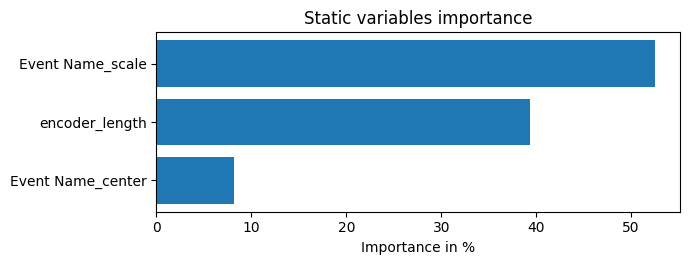

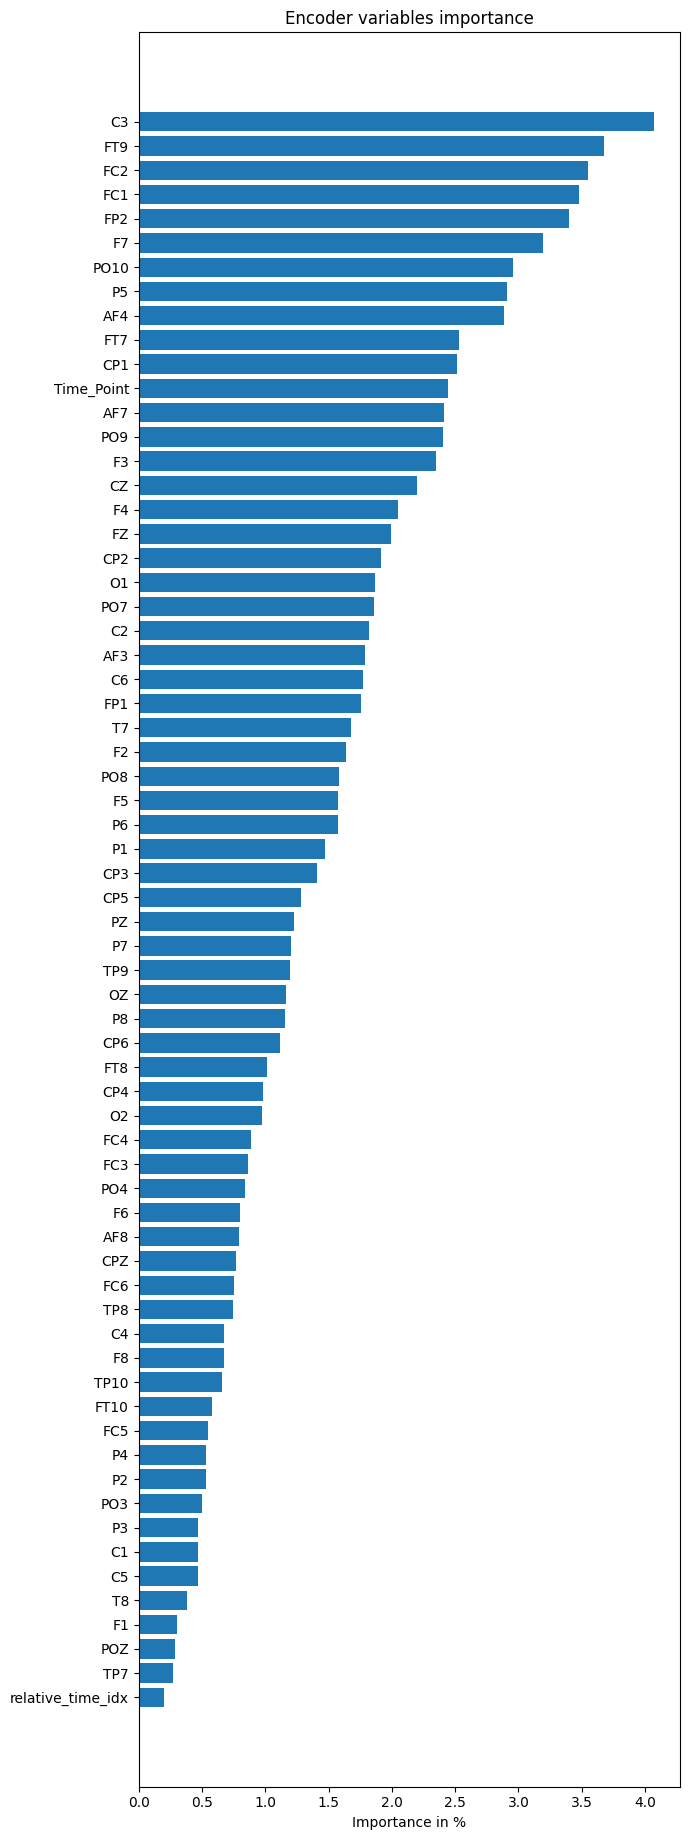

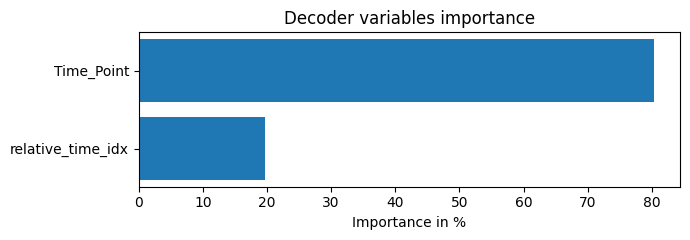

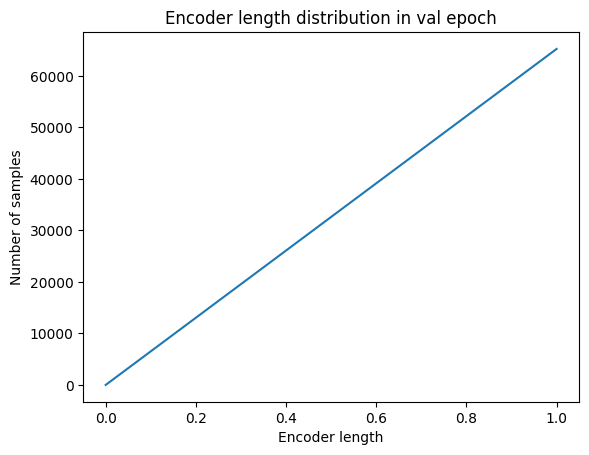

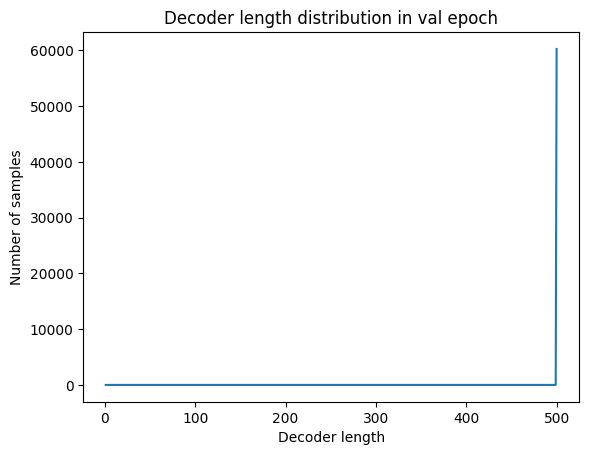

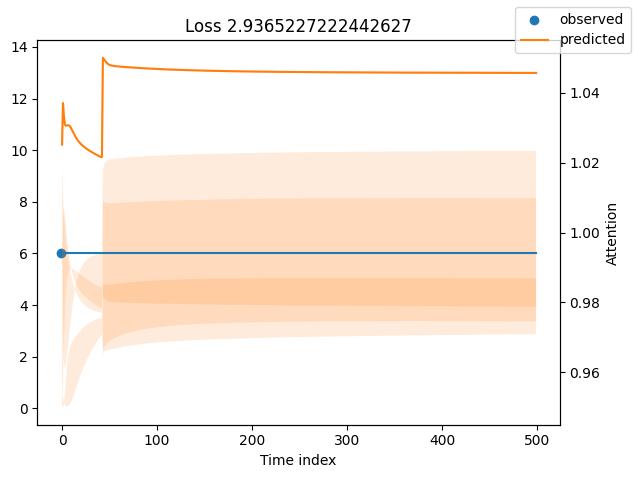

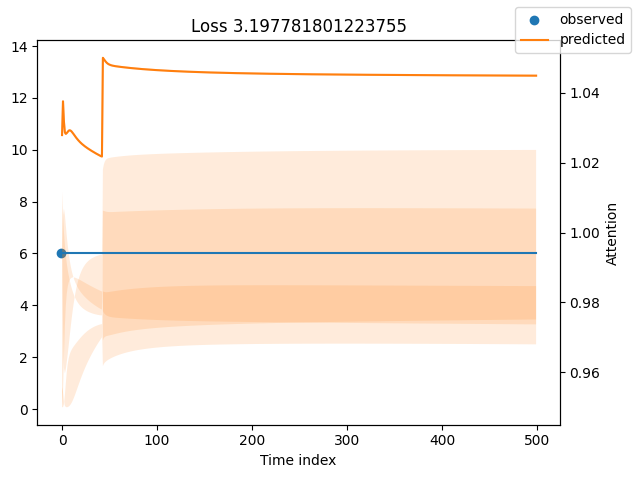

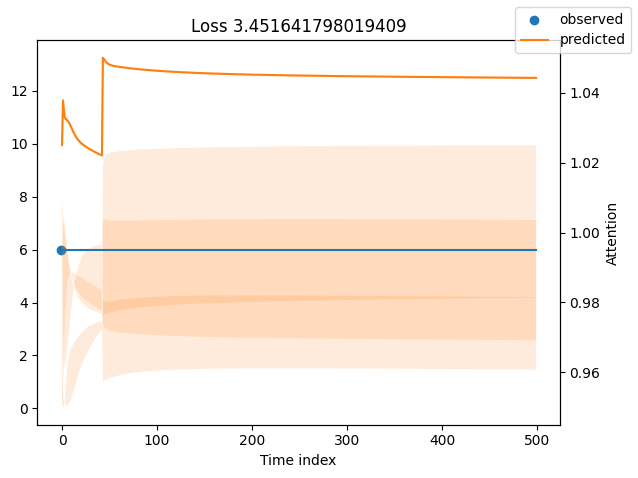

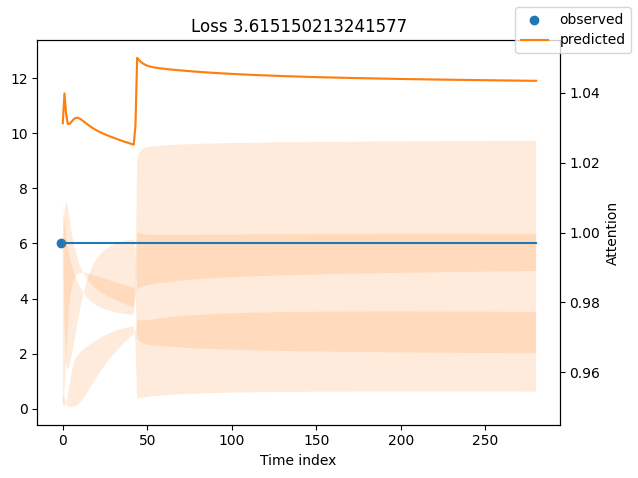

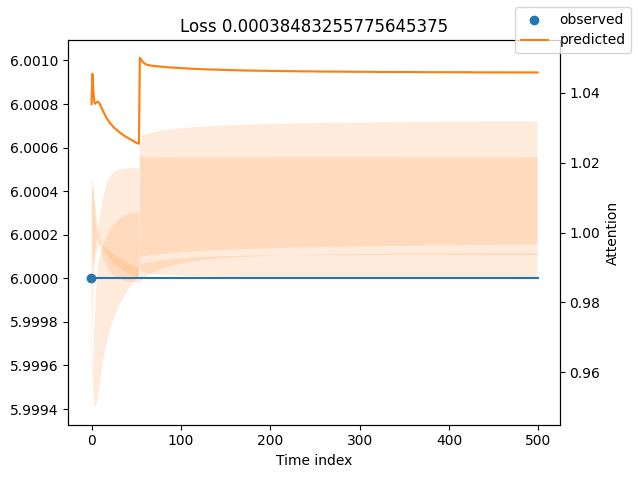

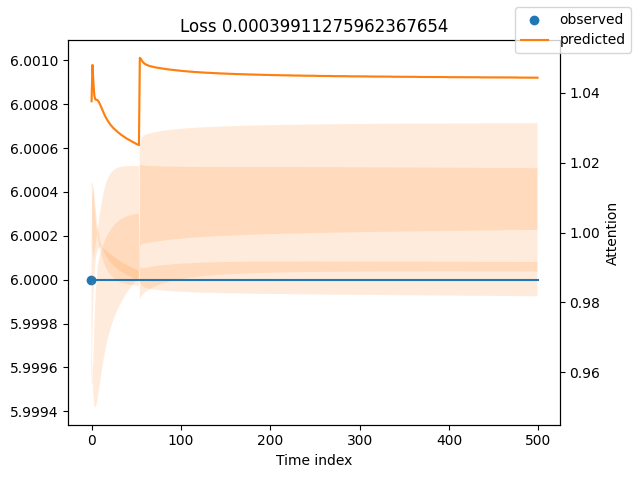

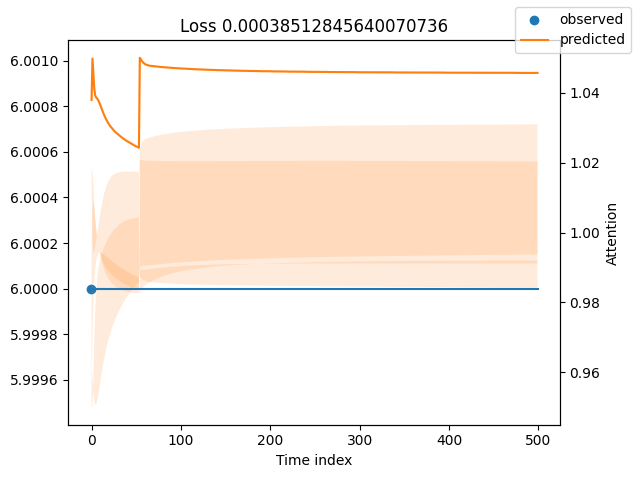

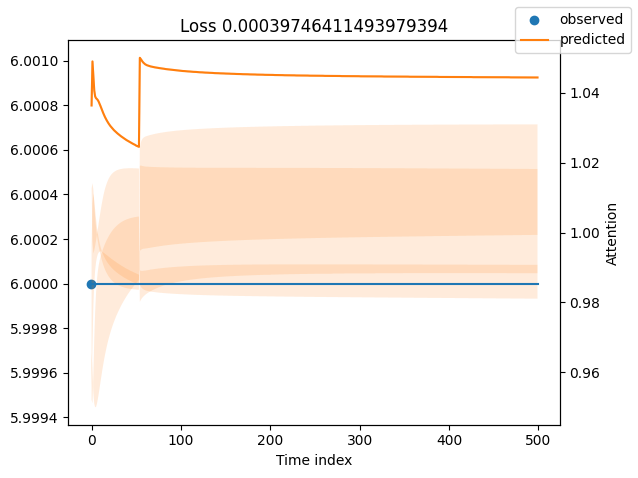

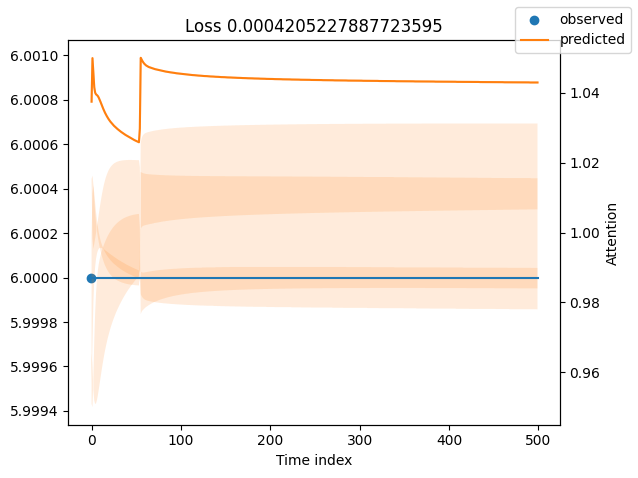

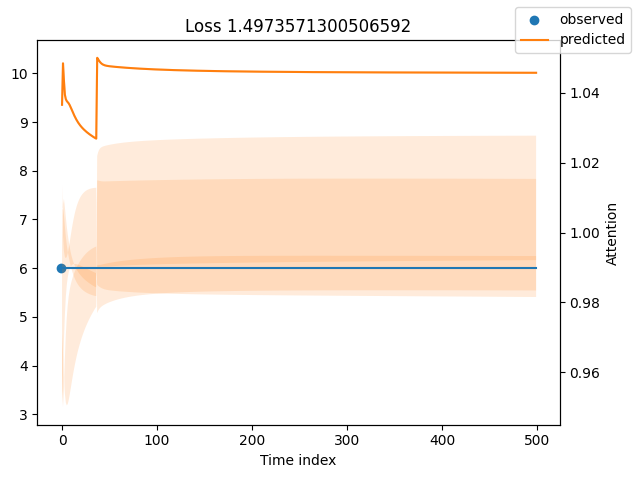

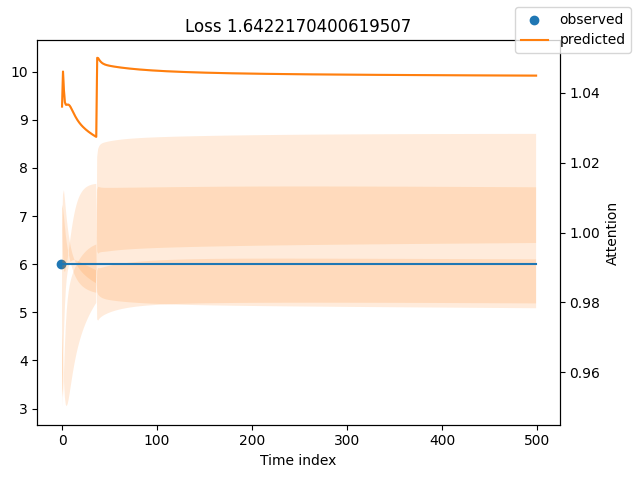

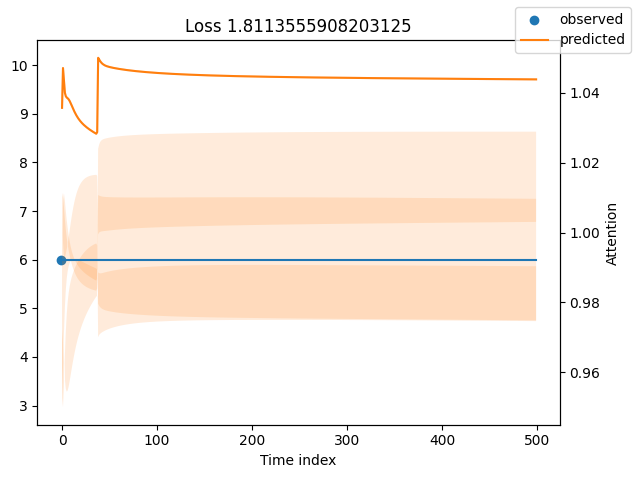

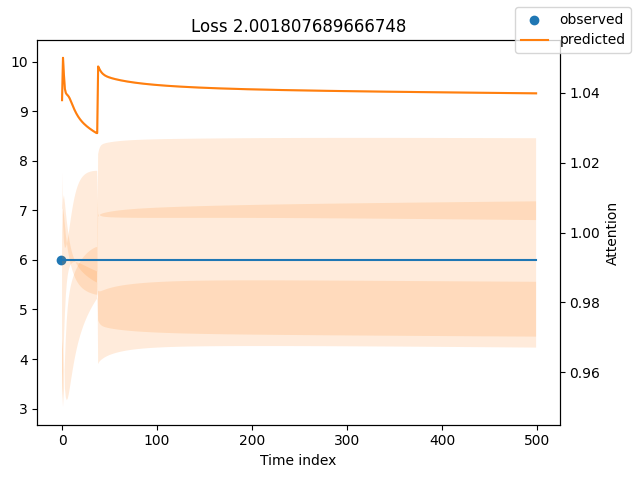

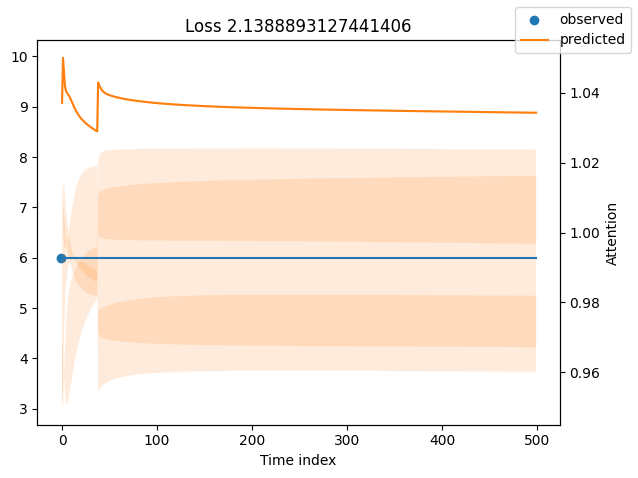

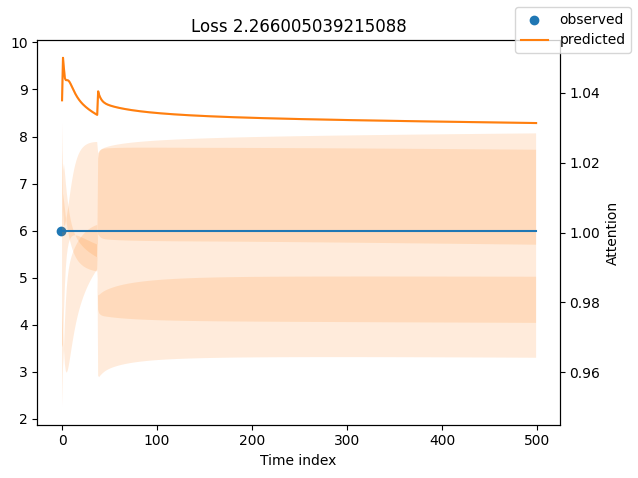

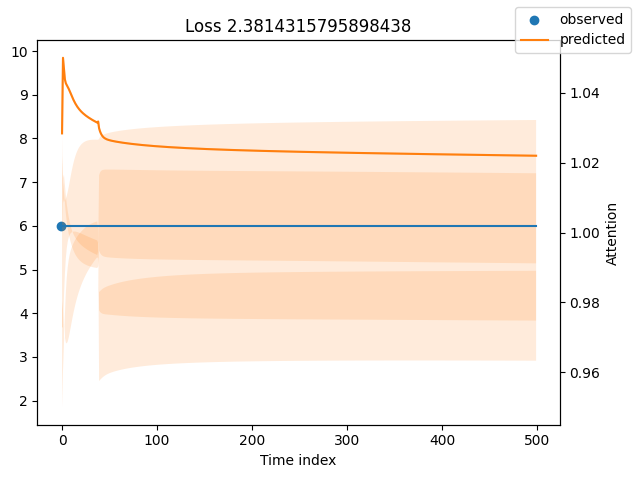

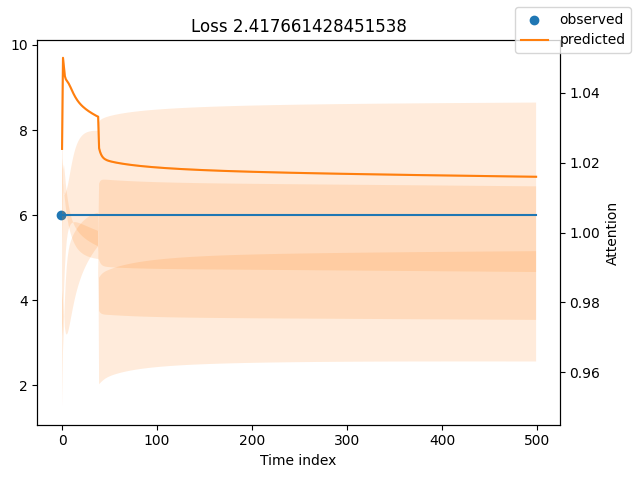

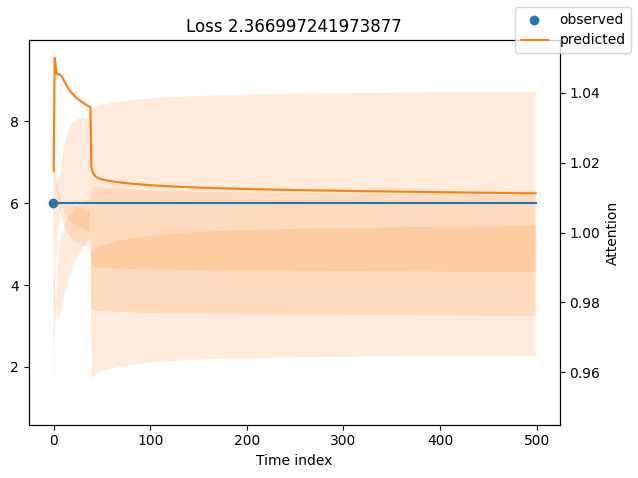

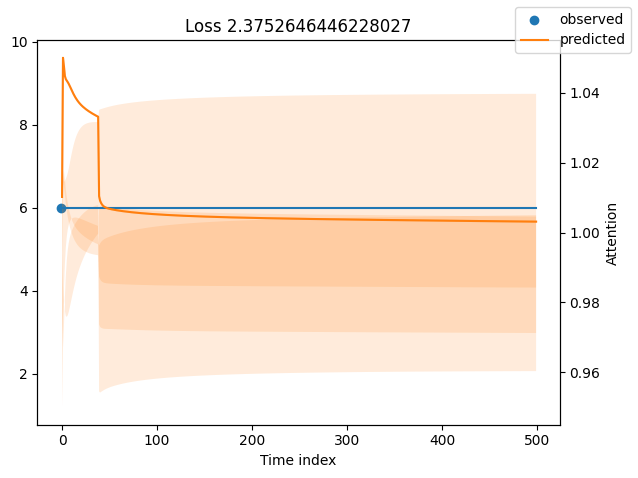

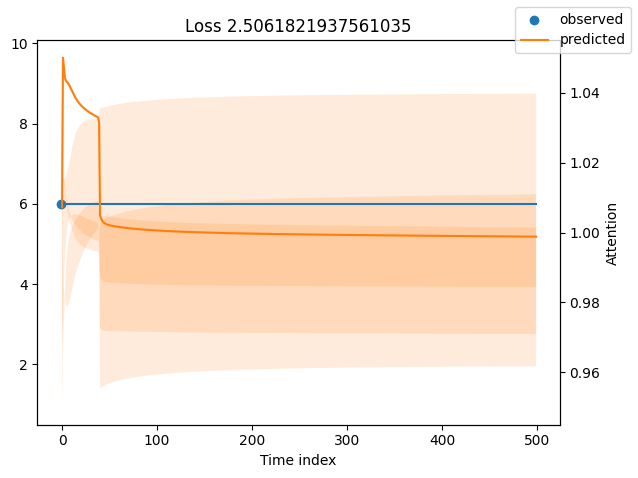

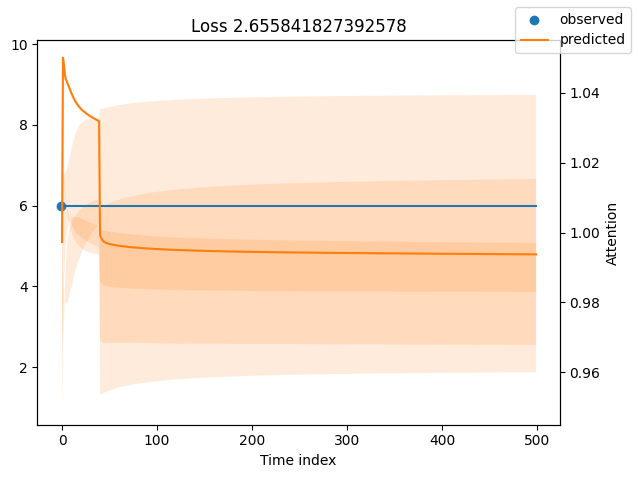

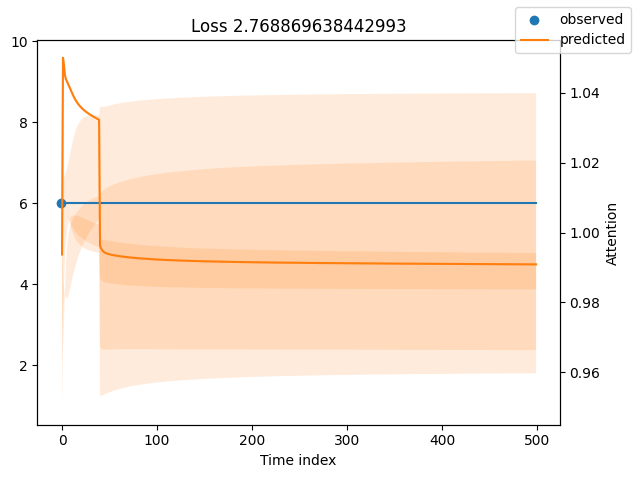

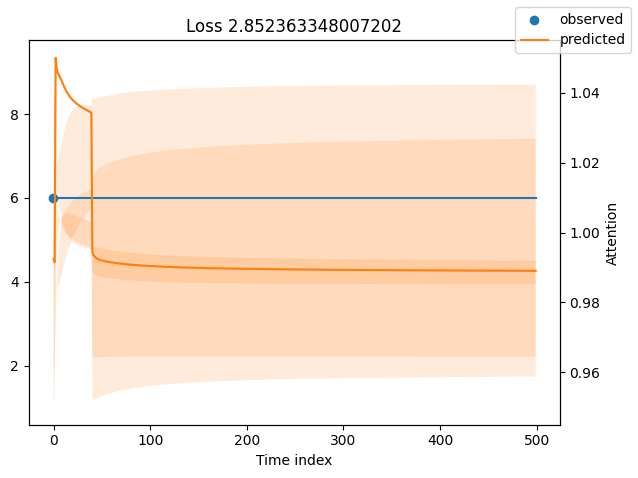

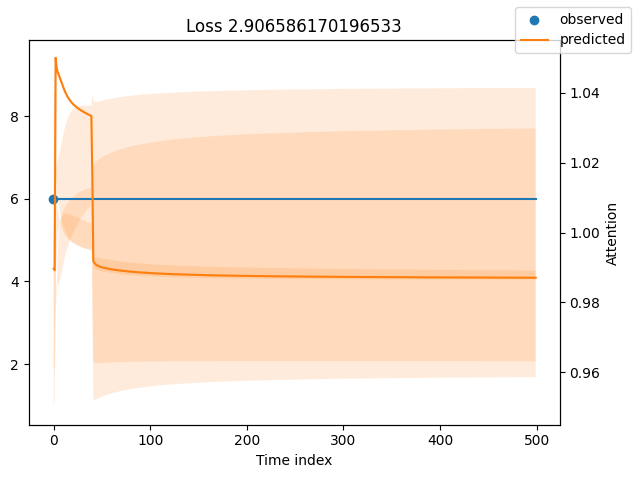

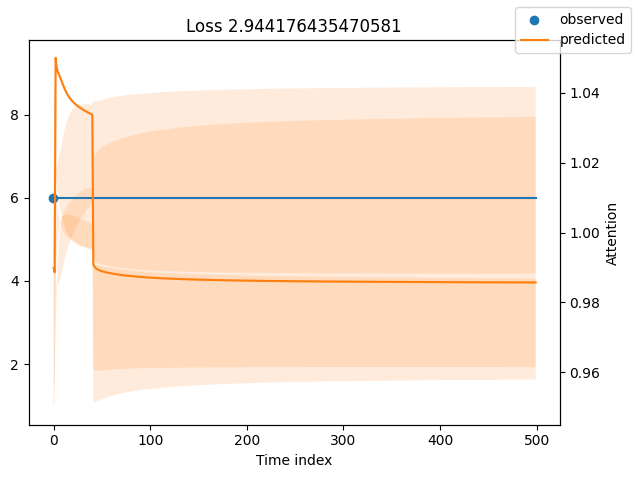

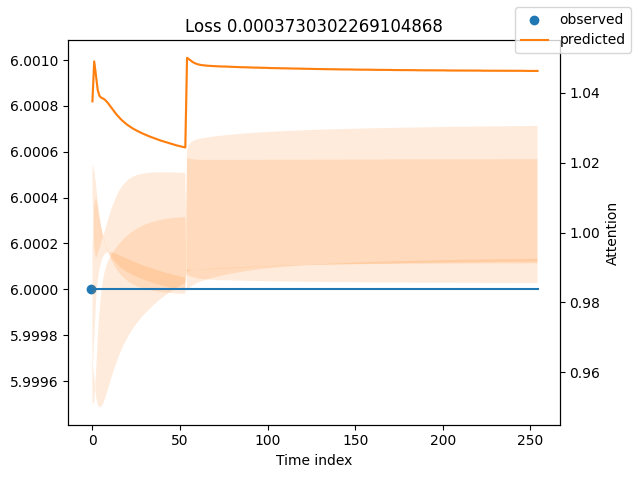

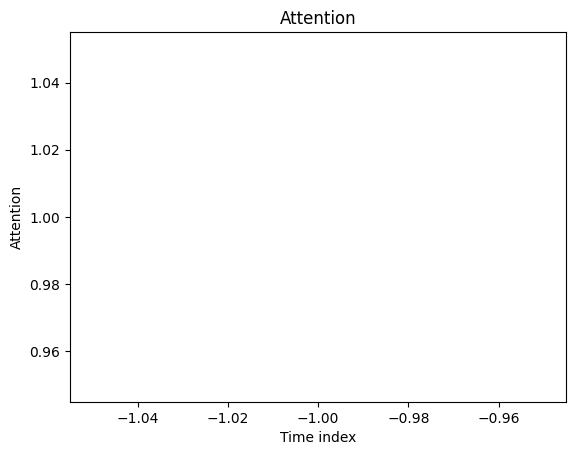

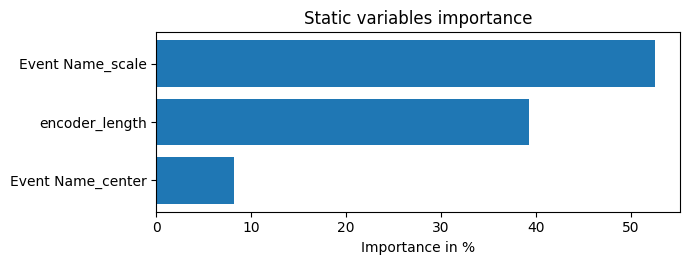

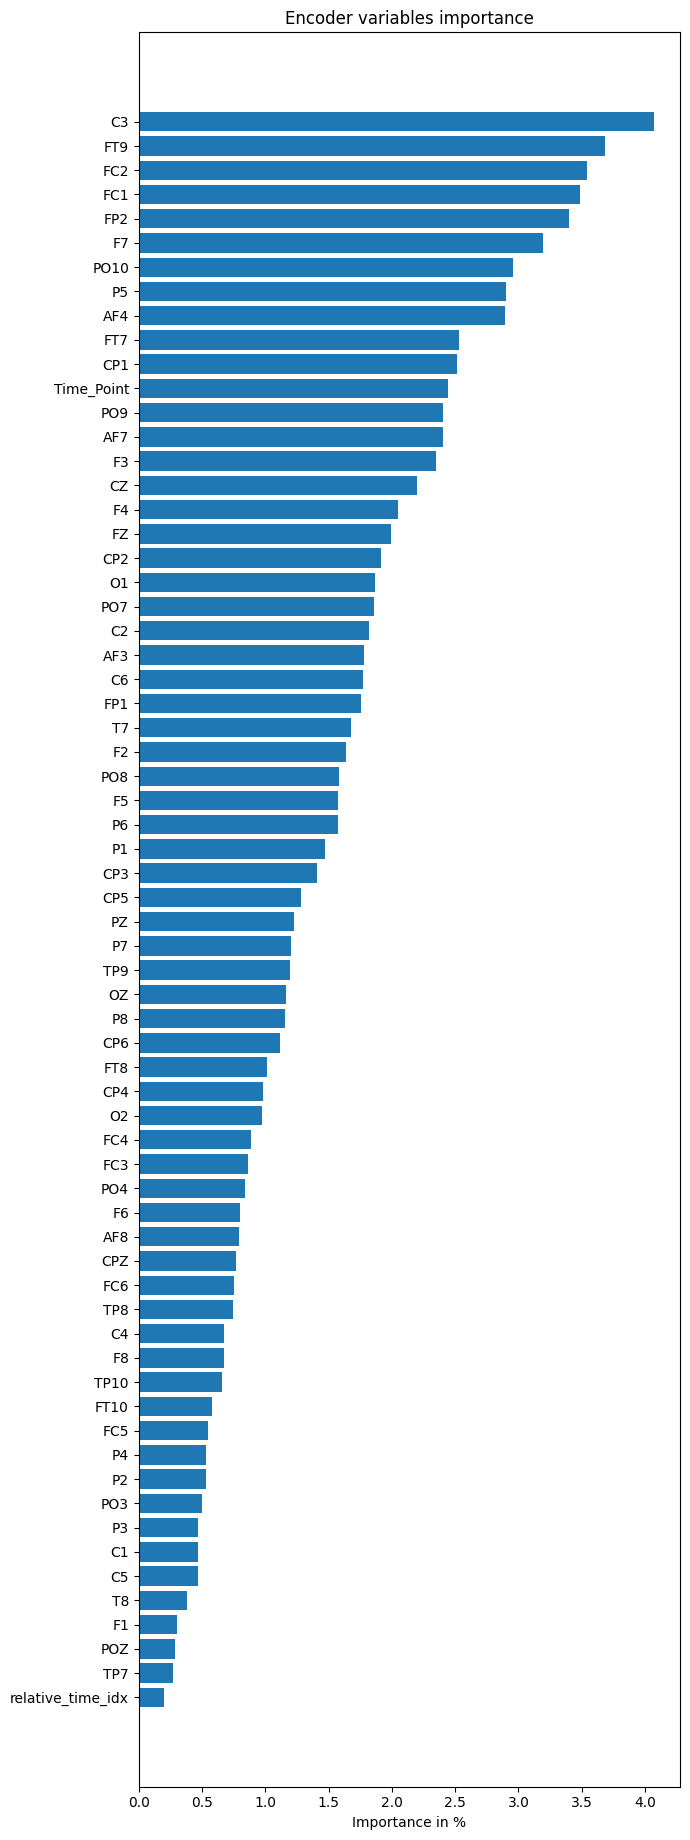

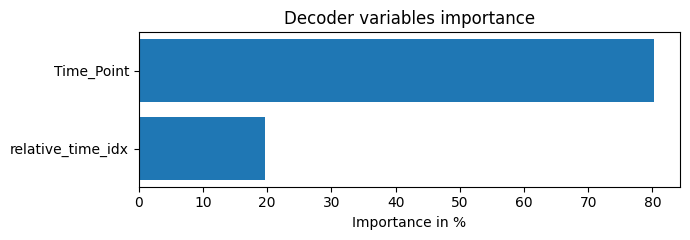

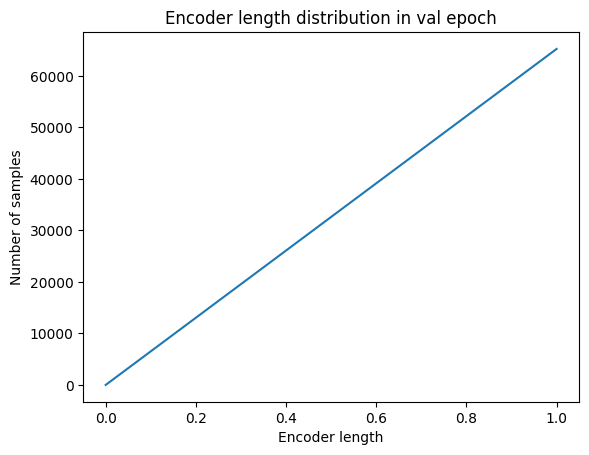

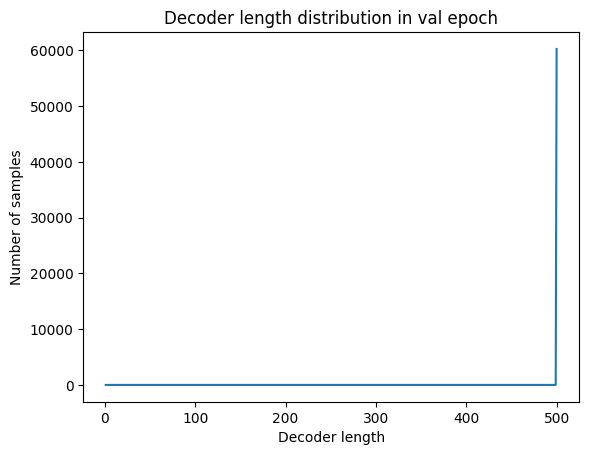

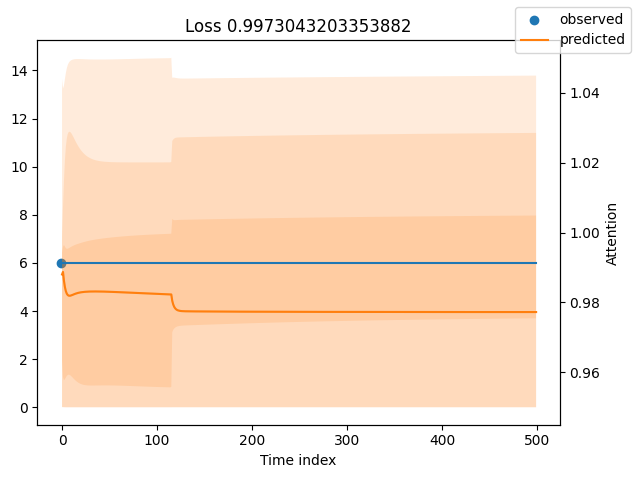

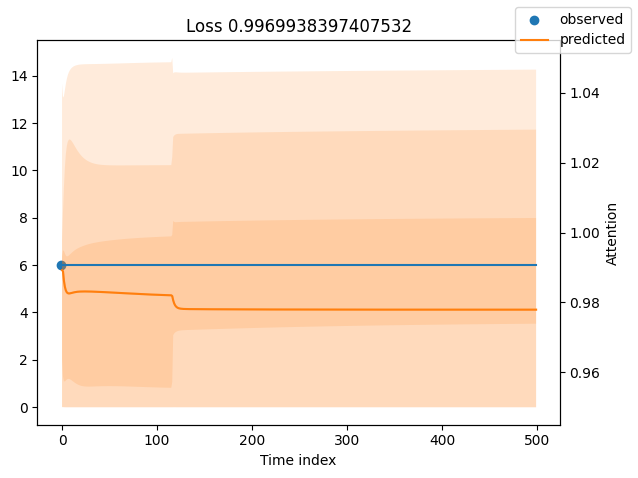

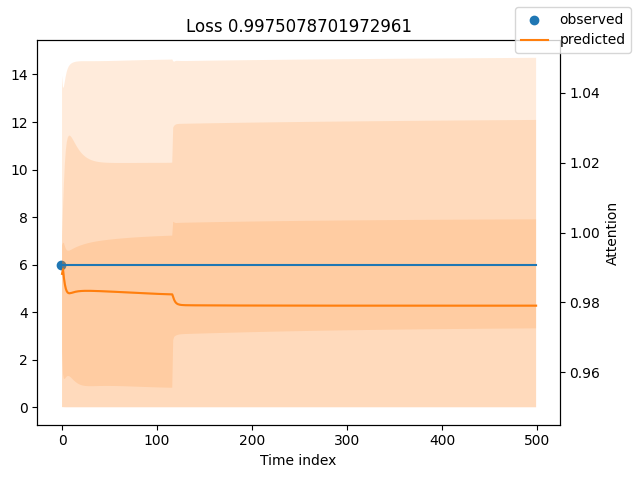

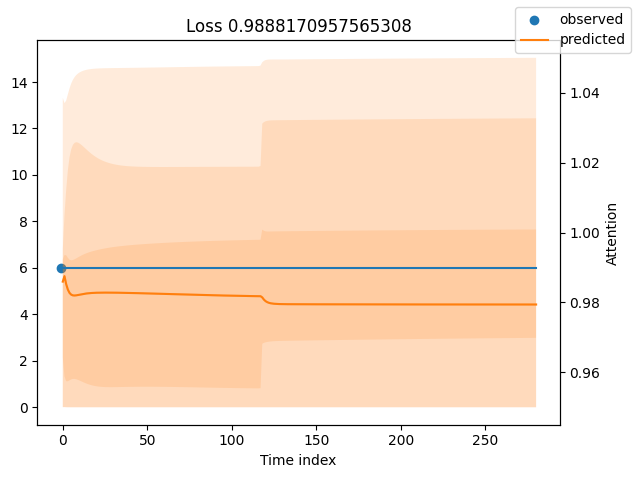

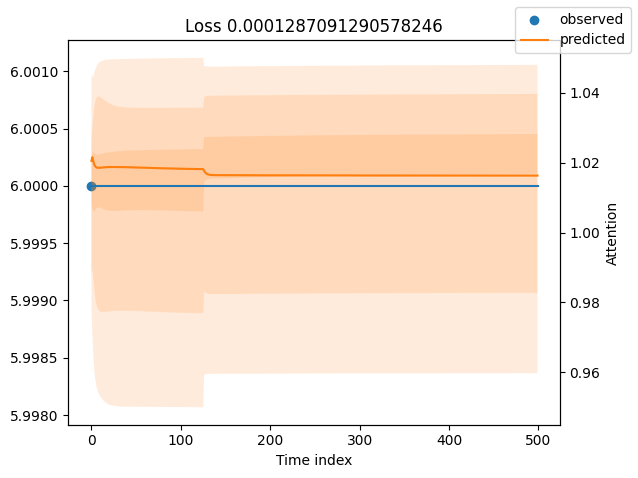

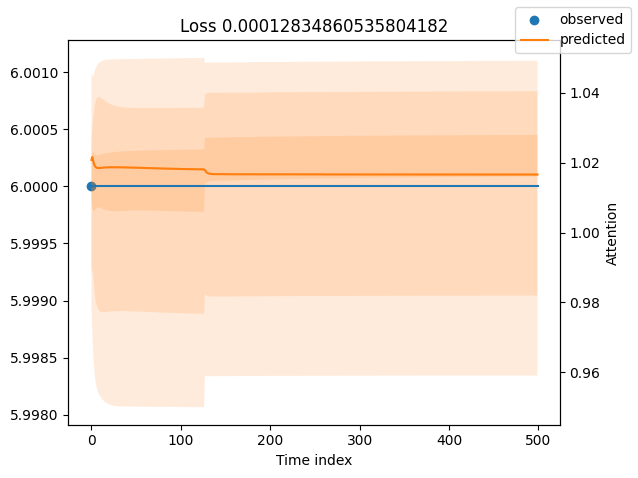

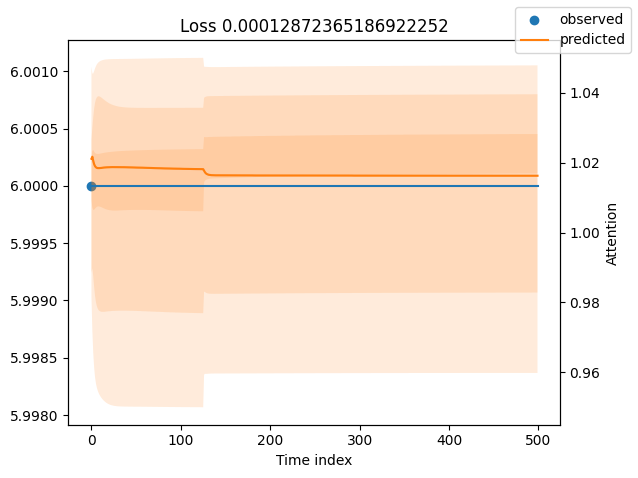

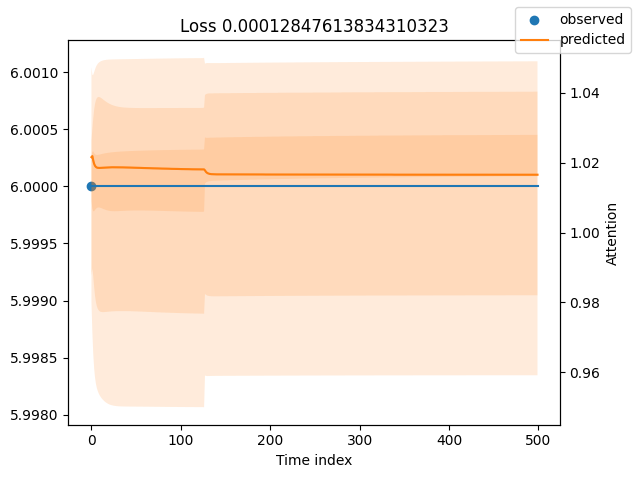

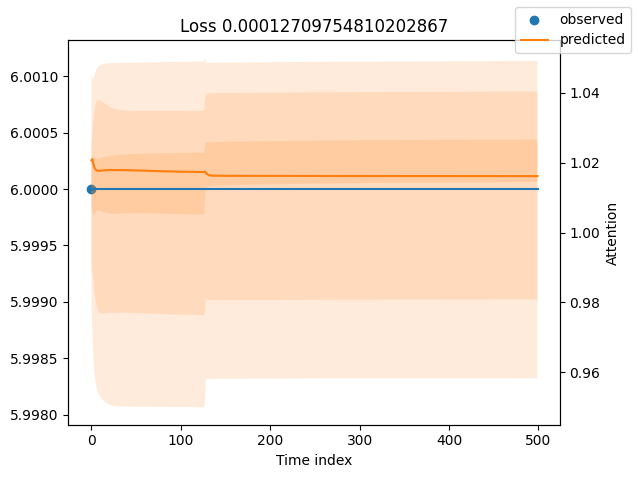

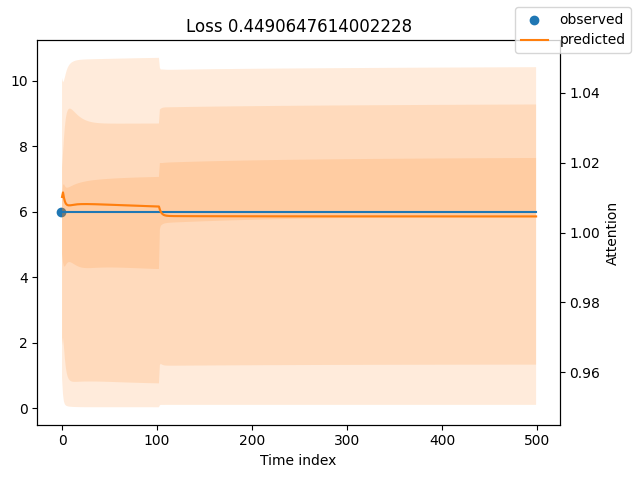

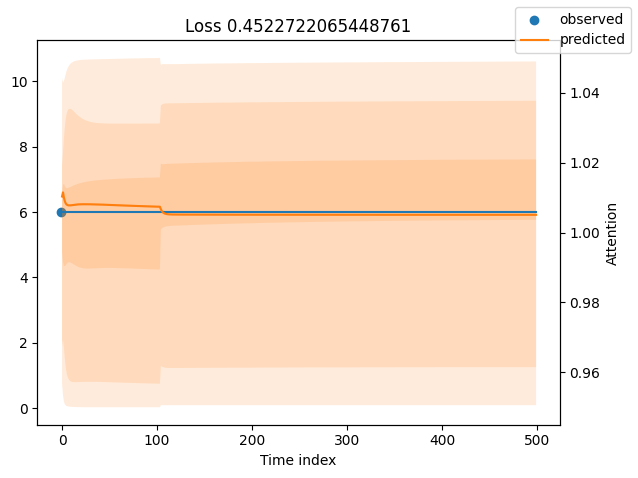

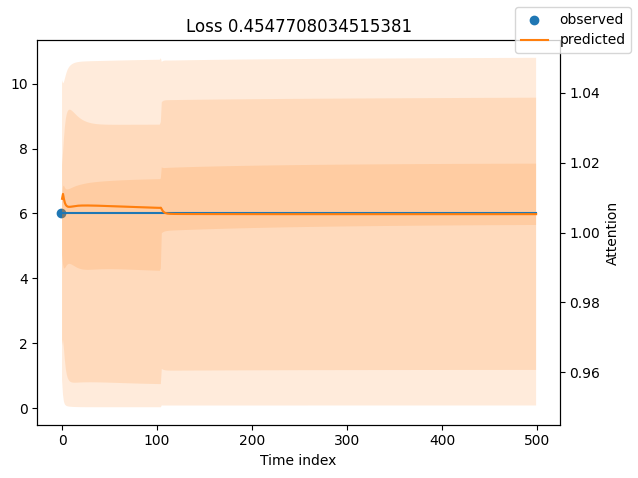

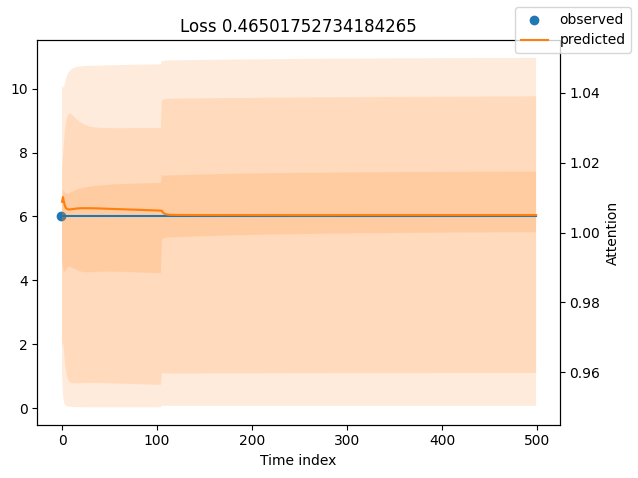

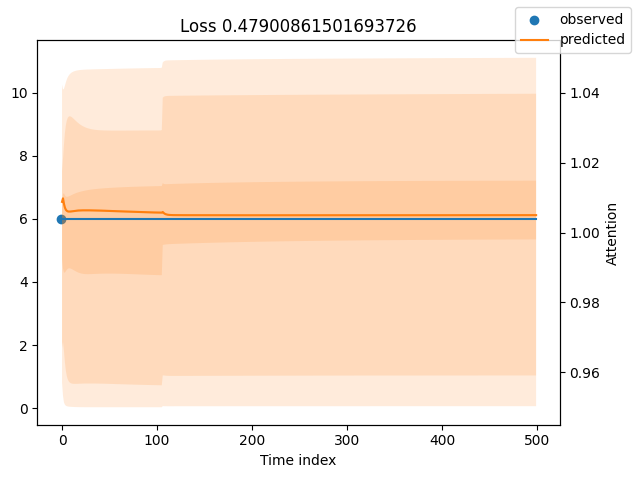

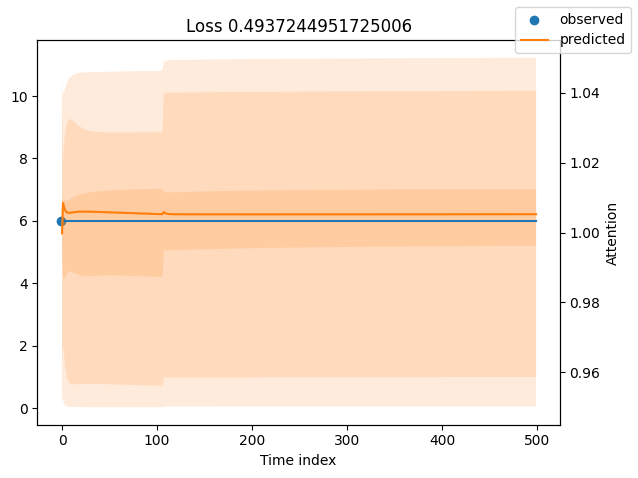

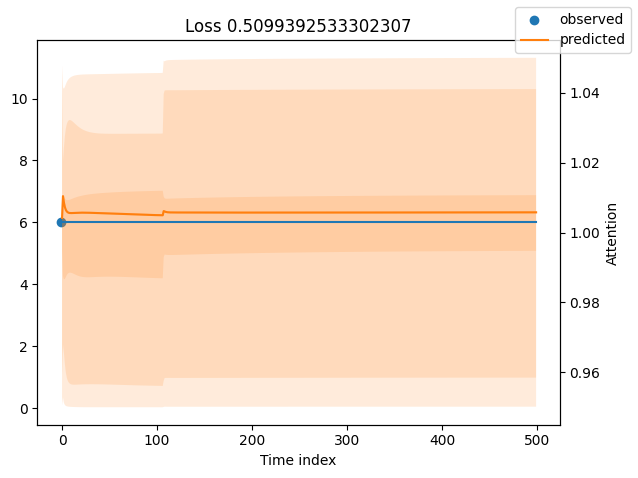

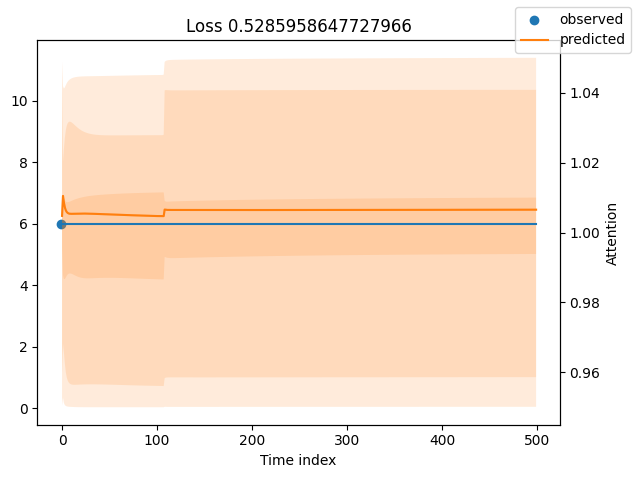

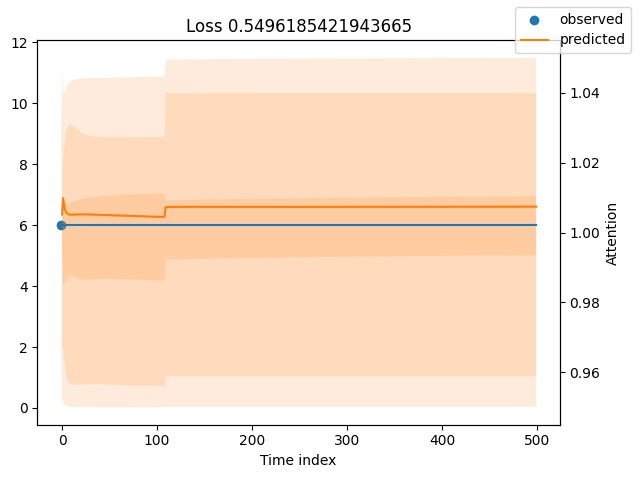

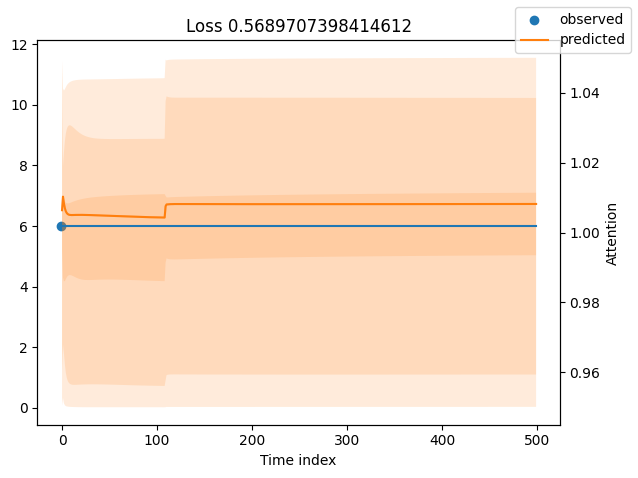

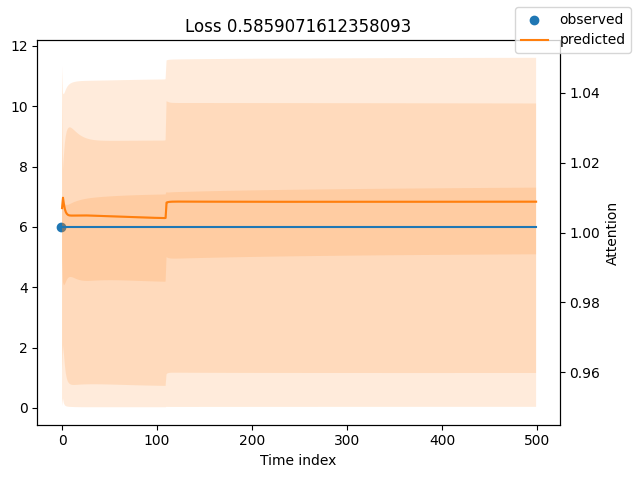

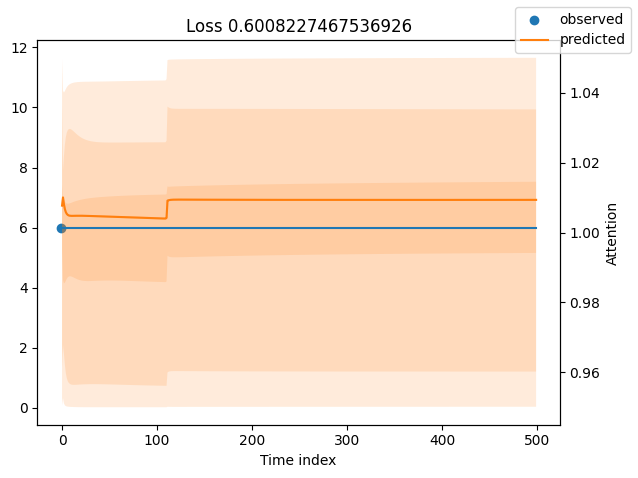

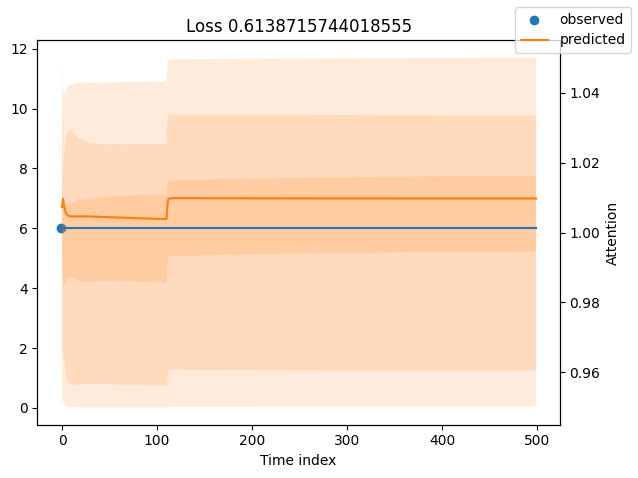

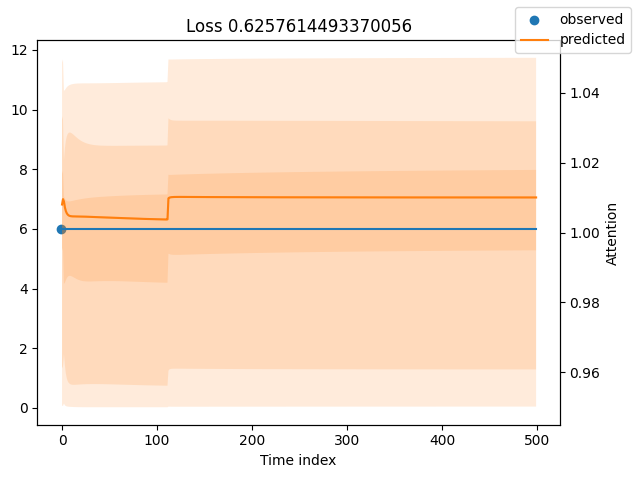

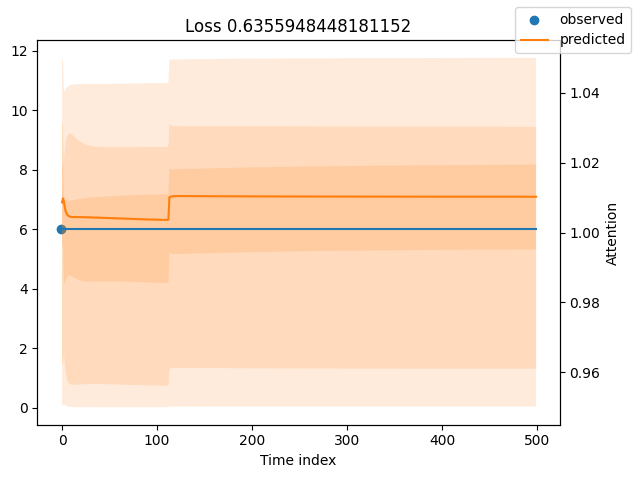

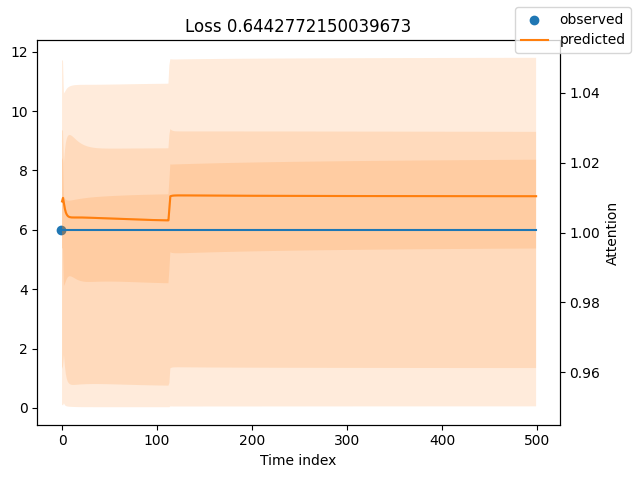

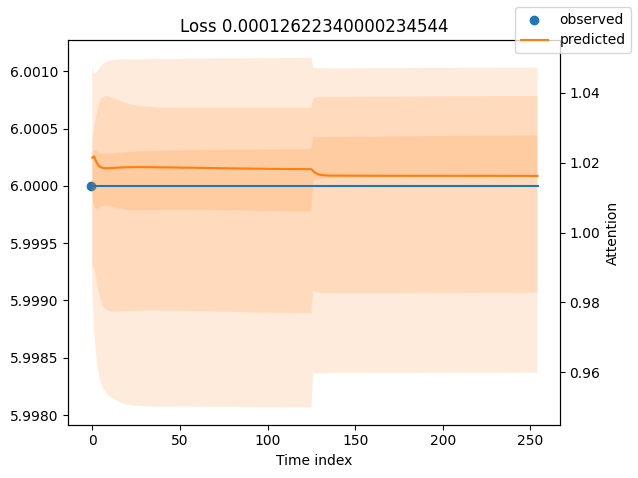

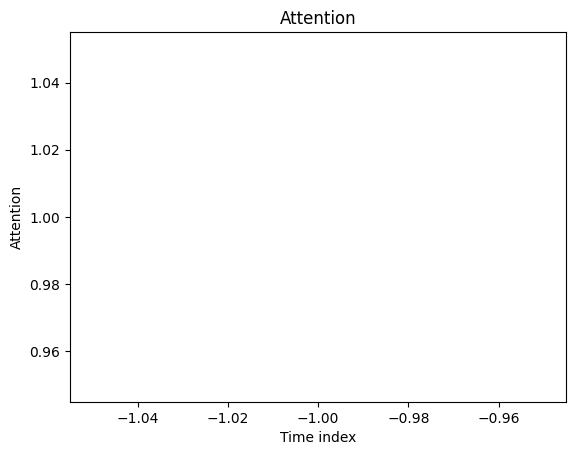

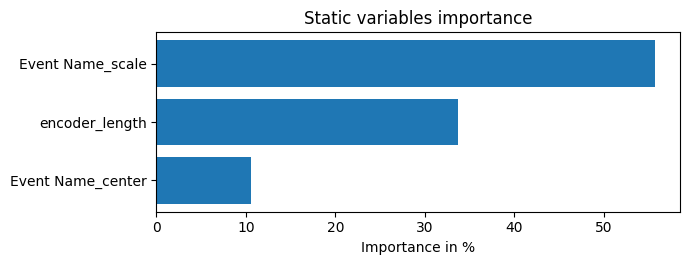

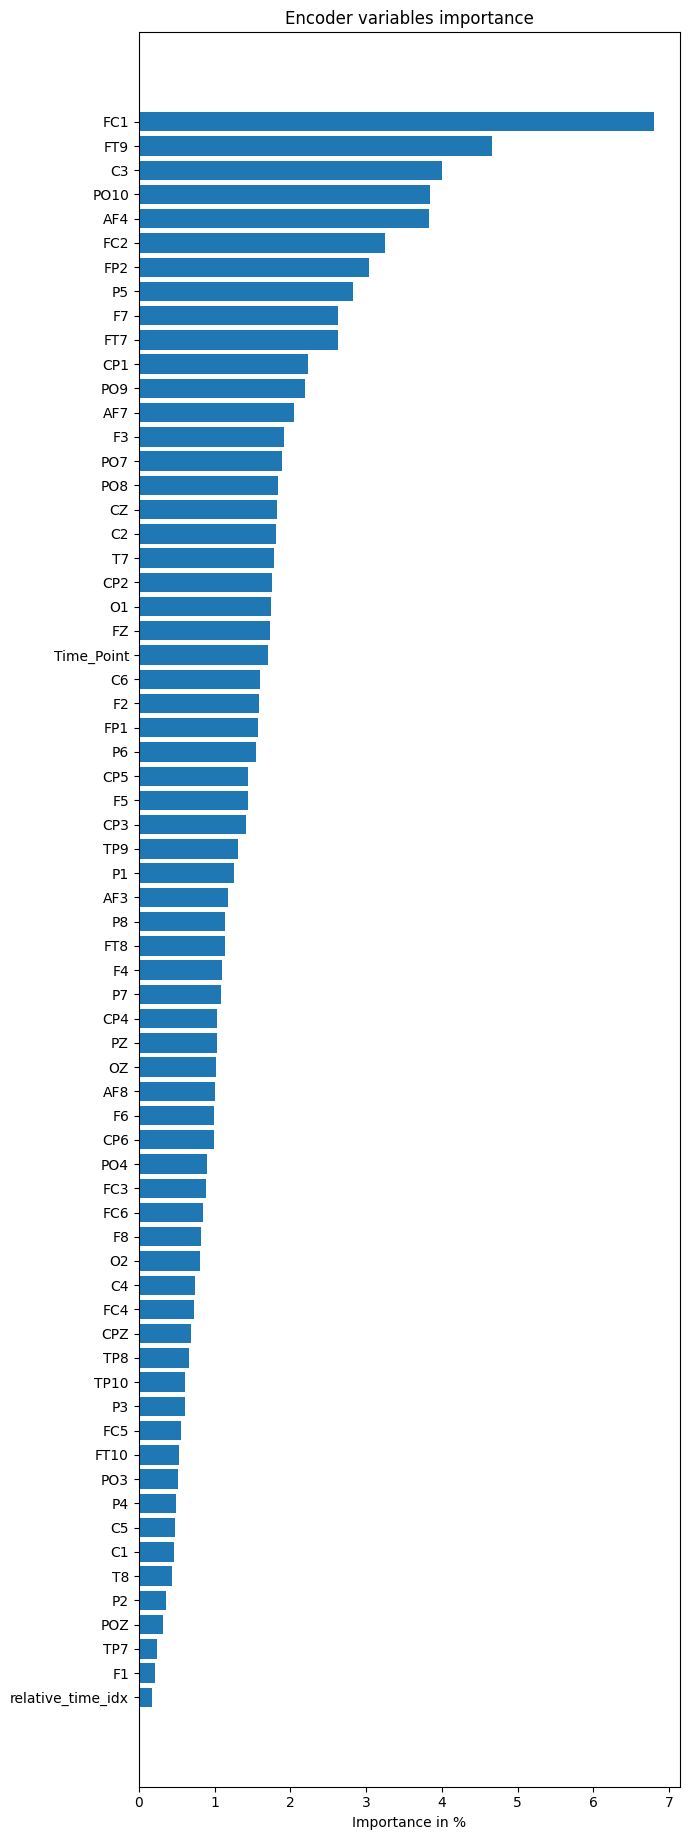

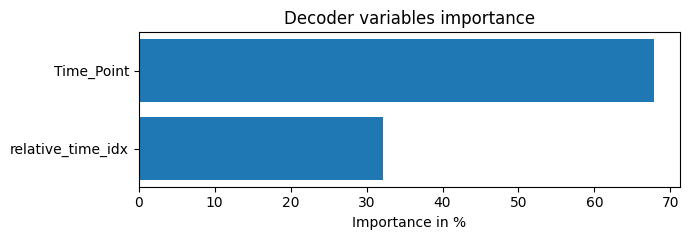

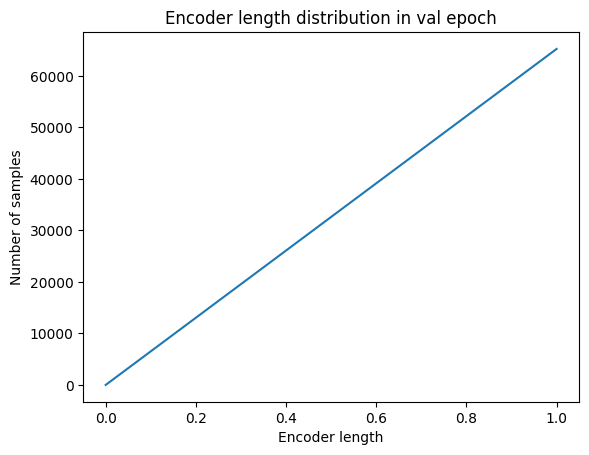

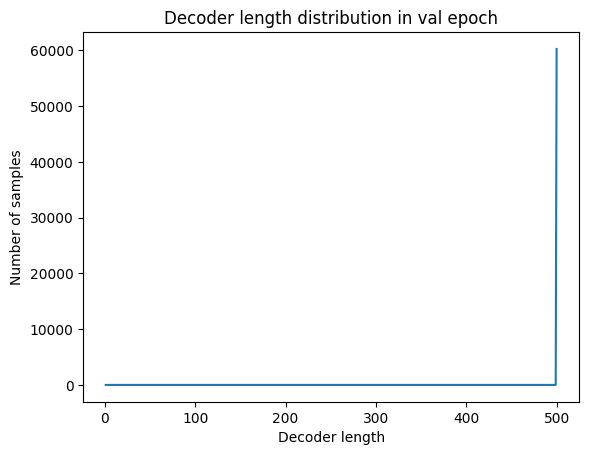

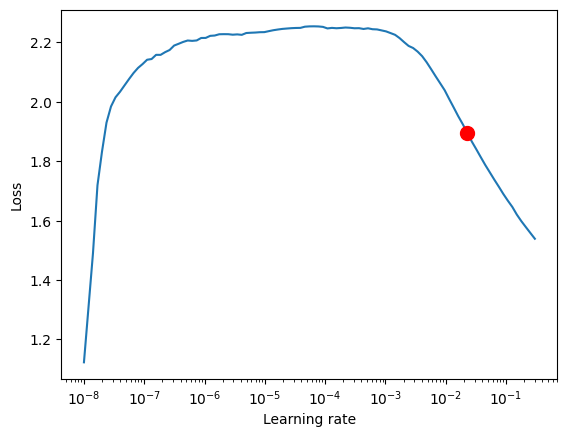

In [7]:
# find the optimal learning rate
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [8]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 2.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 160 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Epoch 0: 100%|█| 30/30 [00:46<00:00,  1.56s/it, v_num=19, train_loss_step=0.654]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:52<00:02,  2.25s/it]
Epoch 0: 100%|█| 30/30 [02:41<00:00,  5.40s/it, v_num=19, train_loss_step=0.654,
Epoch 1: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.512,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  76%|█████████████▊    | 39/51 [01:27<00:26,  2.24s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.23s/it]
Epoch 1: 100%|█| 30/30 [02:41<00:00,  5.39s/it, v_num=19, train_loss_step=0.512,
Epoch 2: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.536,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:50<00:02,  2.22s/it]
Epoch 2: 100%|█| 30/30 [02:41<00:00,  5.39s/it, v_num=19, train_loss_step=0.536,
Epoch 3: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.575,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  53%|█████████▌        | 27/51 [01:00<00:53,  2.23s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.23s/it]
Epoch 3: 100%|█| 30/30 [02:41<00:00,  5.38s/it, v_num=19, train_loss_step=0.575,
Epoch 4: 100%|█| 30/30 [00:47<00:00,  1.60s/it, v_num=19, train_loss_step=0.540,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:49<00:02,  2.18s/it]
Epoch 4: 100%|█| 30/30 [02:39<00:00,  5.32s/it, v_num=19, train_loss_step=0.540,
Epoch 5: 100%|█| 30/30 [00:46<00:00,  1.56s/it, v_num=19, train_loss_step=0.596,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  29%|█████▎            | 15/51 [00:33<01:20,  2.23s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.22s/it]
Epoch 5: 100%|█| 30/30 [02:40<00:00,  5.35s/it, v_num=19, train_loss_step=0.596,
Epoch 6: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.527,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:50<00:02,  2.22s/it]
Epoch 6: 100%|█| 30/30 [02:41<00:00,  5.38s/it, v_num=19, train_loss_step=0.527,
Epoch 7: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.538,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   6%|█                  | 3/51 [00:06<01:47,  2.24s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:49<00:02,  2.19s/it]
Epoch 7: 100%|█| 30/30 [02:39<00:00,  5.32s/it, v_num=19, train_loss_step=0.538,
Epoch 8: 100%|█| 30/30 [00:46<00:00,  1.56s/it, v_num=19, train_loss_step=0.513,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  90%|████████████████▏ | 46/51 [01:42<00:11,  2.24s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.23s/it]
Epoch 8: 100%|█| 30/30 [02:40<00:00,  5.36s/it, v_num=19, train_loss_step=0.513,
Epoch 9: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.499,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.23s/it]
Epoch 9: 100%|█| 30/30 [02:42<00:00,  5.40s/it, v_num=19, train_loss_step=0.499,
Epoch 10: 100%|█| 30/30 [10:38<00:00, 21.29s/it, v_num=19, train_loss_step=0.557
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  67%|████████████      | 34/51 [01:13<00:36,  2.16s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:47<00:02,  2.16s/it]
Epoch 10: 100%|█| 30/30 [12:29<00:00, 24.97s/it, v_num=19, train_loss_step=0.557
Epoch 11: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.598
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.22s/it]
Epoch 11: 100%|█| 30/30 [02:41<00:00,  5.37s/it, v_num=19, train_loss_step=0.598
Epoch 12: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.477
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  43%|███████▊          | 22/51 [00:49<01:04,  2.24s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:52<00:02,  2.24s/it]
Epoch 12: 100%|█| 30/30 [02:42<00:00,  5.42s/it, v_num=19, train_loss_step=0.477
Epoch 13: 100%|█| 30/30 [00:48<00:00,  1.61s/it, v_num=19, train_loss_step=0.545
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:49<00:02,  2.20s/it]
Epoch 13: 100%|█| 30/30 [02:40<00:00,  5.36s/it, v_num=19, train_loss_step=0.545
Epoch 14: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.500
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  20%|███▌              | 10/51 [00:22<01:33,  2.28s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.23s/it]
Epoch 14: 100%|█| 30/30 [02:41<00:00,  5.39s/it, v_num=19, train_loss_step=0.500
Epoch 15: 100%|█| 30/30 [00:47<00:00,  1.57s/it, v_num=19, train_loss_step=0.490
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:54<00:02,  2.30s/it]
Epoch 15: 100%|█| 30/30 [02:44<00:00,  5.48s/it, v_num=19, train_loss_step=0.490
Epoch 16: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.580
Validation: 0it [00:00, ?it/s]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:53<00:02,  2.27s/it]
Epoch 16: 100%|█| 30/30 [02:44<00:00,  5.47s/it, v_num=19, train_loss_step=0.580
Epoch 17: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.632
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  80%|██████████████▍   | 41/51 [01:32<00:22,  2.25s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.23s/it]
Epoch 17: 100%|█| 30/30 [02:42<00:00,  5.41s/it, v_num=19, train_loss_step=0.632
Epoch 18: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.511
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:51<00:02,  2.22s/it]
Epoch 18: 100%|█| 30/30 [02:41<00:00,  5.37s/it, v_num=19, train_loss_step=0.511
Epoch 19: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.543
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  57%|██████████▏       | 29/51 [01:06<00:50,  2.29s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:53<00:02,  2.26s/it]
Epoch 19: 100%|█| 30/30 [02:42<00:00,  5.43s/it, v_num=19, train_loss_step=0.543
Epoch 20: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.492
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.33s/it]
Epoch 20: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.492
Epoch 21: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.549
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  33%|██████            | 17/51 [00:38<01:17,  2.27s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:54<00:02,  2.30s/it]
Epoch 21: 100%|█| 30/30 [02:45<00:00,  5.52s/it, v_num=19, train_loss_step=0.549
Epoch 22: 100%|█| 30/30 [00:49<00:00,  1.64s/it, v_num=19, train_loss_step=0.559
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [11:26<00:13, 13.74s/it]
Epoch 22: 100%|█| 30/30 [12:18<00:00, 24.62s/it, v_num=19, train_loss_step=0.559
Epoch 23: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.520
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  10%|█▊                 | 5/51 [00:11<01:49,  2.39s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:54<00:02,  2.30s/it]
Epoch 23: 100%|█| 30/30 [02:46<00:00,  5.54s/it, v_num=19, train_loss_step=0.520
Epoch 24: 100%|█| 30/30 [00:47<00:00,  1.60s/it, v_num=19, train_loss_step=0.563
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  94%|████████████████▉ | 48/51 [01:52<00:07,  2.34s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.33s/it]
Epoch 24: 100%|█| 30/30 [02:47<00:00,  5.57s/it, v_num=19, train_loss_step=0.563
Epoch 25: 100%|█| 30/30 [00:47<00:00,  1.60s/it, v_num=19, train_loss_step=0.532
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:58<00:02,  2.37s/it]
Epoch 25: 100%|█| 30/30 [02:49<00:00,  5.64s/it, v_num=19, train_loss_step=0.532
Epoch 26: 100%|█| 30/30 [00:48<00:00,  1.61s/it, v_num=19, train_loss_step=0.535
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  71%|████████████▋     | 36/51 [01:24<00:35,  2.35s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:59<00:02,  2.40s/it]
Epoch 26: 100%|█| 30/30 [02:50<00:00,  5.70s/it, v_num=19, train_loss_step=0.535
Epoch 27: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.505
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.33s/it]
Epoch 27: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.505
Epoch 28: 100%|█| 30/30 [00:47<00:00,  1.57s/it, v_num=19, train_loss_step=0.554
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  47%|████████▍         | 24/51 [01:00<01:08,  2.53s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:03<00:02,  2.47s/it]
Epoch 28: 100%|█| 30/30 [02:53<00:00,  5.78s/it, v_num=19, train_loss_step=0.554
Epoch 29: 100%|█| 30/30 [00:48<00:00,  1.62s/it, v_num=19, train_loss_step=0.500
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.43s/it]
Epoch 29: 100%|█| 30/30 [02:52<00:00,  5.76s/it, v_num=19, train_loss_step=0.500
Epoch 30: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.468
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  24%|████▏             | 12/51 [00:28<01:32,  2.36s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.33s/it]
Epoch 30: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.468
Epoch 31: 100%|█| 30/30 [00:47<00:00,  1.60s/it, v_num=19, train_loss_step=0.541
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:57<00:02,  2.34s/it]
Epoch 31: 100%|█| 30/30 [02:47<00:00,  5.59s/it, v_num=19, train_loss_step=0.541
Epoch 32: 100%|█| 30/30 [00:47<00:00,  1.57s/it, v_num=19, train_loss_step=0.503
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                           | 0/51 [00:00<?, ?it/s]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.34s/it]
Epoch 32: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.503
Epoch 33: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.486
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  84%|███████████████▏  | 43/51 [01:37<00:18,  2.27s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:53<00:02,  2.26s/it]
Epoch 33: 100%|█| 30/30 [02:44<00:00,  5.47s/it, v_num=19, train_loss_step=0.486
Epoch 34: 100%|█| 30/30 [17:31<00:00, 35.07s/it, v_num=19, train_loss_step=0.457
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:02<00:02,  2.46s/it]
Epoch 34: 100%|█| 30/30 [19:37<00:00, 39.26s/it, v_num=19, train_loss_step=0.457
Epoch 35: 100%|█| 30/30 [00:48<00:00,  1.61s/it, v_num=19, train_loss_step=0.605
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  61%|██████████▉       | 31/51 [01:14<00:47,  2.39s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [19:22<00:23, 23.25s/it]
Epoch 35: 100%|█| 30/30 [20:15<00:00, 40.52s/it, v_num=19, train_loss_step=0.605
Epoch 36: 100%|█| 30/30 [16:30<00:00, 33.03s/it, v_num=19, train_loss_step=0.550
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:03<00:02,  2.47s/it]
Epoch 36: 100%|█| 30/30 [18:37<00:00, 37.24s/it, v_num=19, train_loss_step=0.550
Epoch 37: 100%|█| 30/30 [00:49<00:00,  1.64s/it, v_num=19, train_loss_step=0.605
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  37%|██████▋           | 19/51 [00:46<01:18,  2.45s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.43s/it]
Epoch 37: 100%|█| 30/30 [02:53<00:00,  5.79s/it, v_num=19, train_loss_step=0.605
Epoch 38: 100%|█| 30/30 [00:49<00:00,  1.63s/it, v_num=19, train_loss_step=0.497
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [18:34<00:22, 22.29s/it]
Epoch 38: 100%|█| 30/30 [19:26<00:00, 38.89s/it, v_num=19, train_loss_step=0.497
Epoch 39: 100%|█| 30/30 [16:08<00:00, 32.27s/it, v_num=19, train_loss_step=0.549
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  14%|██▌                | 7/51 [00:17<01:48,  2.46s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [17:33<00:21, 21.07s/it]
Epoch 39: 100%|█| 30/30 [33:44<00:00, 67.48s/it, v_num=19, train_loss_step=0.549
Epoch 40: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.476
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [32:45<00:39, 39.30s/it]


Epoch 40: 100%|█| 30/30 [33:35<00:00, 67.19s/it, v_num=19, train_loss_step=0.476
Epoch 41: 100%|█| 30/30 [15:50<00:00, 31.67s/it, v_num=19, train_loss_step=0.591
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:57<00:02,  2.35s/it]
Epoch 41: 100%|█| 30/30 [17:50<00:00, 35.69s/it, v_num=19, train_loss_step=0.591
Epoch 42: 100%|█| 30/30 [00:48<00:00,  1.61s/it, v_num=19, train_loss_step=0.571
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  75%|█████████████▍    | 38/51 [16:42<05:42, 26.38s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [17:11<00:20, 20.63s/it]
Epoch 42: 100%|█| 30/30 [18:02<00:00, 36.08s/it, v_num=19, train_loss_step=0.571
Epoch 43: 100%|█| 30/30 [00:47<00:00,  1.60s/it, v_num=19, train_loss_step=0.450
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [51:15<01:01, 61.52s/it]
Epoch 43: 100%|█| 30/30 [52:06<00:00, 104.22s/it, v_num=19, train_loss_step=0.45
Epoch 44: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.455
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  51%|█████████▏        | 26/51 [16:33<15:55, 38.20s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [17:29<00:20, 21.00s/it]
Epoch 44: 100%|█| 30/30 [18:20<00:00, 36.67s/it, v_num=19, train_loss_step=0.455
Epoch 45: 100%|█| 30/30 [16:17<00:00, 32.58s/it, v_num=19, train_loss_step=0.497
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [51:50<01:02, 62.20s/it]
Epoch 45: 100%|█| 30/30 [1:08:10<00:00, 136.35s/it, v_num=19, train_loss_step=0.
Epoch 46: 100%|█| 30/30 [17:05<00:00, 34.18s/it, v_num=19, train_loss_step=0.500
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  27%|████▉             | 14/51 [15:56<42:07, 68.30s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [32:45<00:39, 39.31s/it]
Epoch 46: 100%|█| 30/30 [49:56<00:00, 99.90s/it, v_num=19, train_loss_step=0.500
Epoch 47: 100%|█| 30/30 [00:46<00:00,  1.55s/it, v_num=19, train_loss_step=0.500
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [38:22<00:46, 46.06s/it]
Epoch 47: 100%|█| 30/30 [39:12<00:00, 78.41s/it, v_num=19, train_loss_step=0.500
Epoch 48: 100%|█| 30/30 [17:07<00:00, 34.24s/it, v_num=19, train_loss_step=0.483
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   4%|▋                  | 2/51 [00:05<02:11,  2.69s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [34:33<00:41, 41.46s/it]
Epoch 48: 100%|█| 30/30 [51:43<00:00, 103.44s/it, v_num=19, train_loss_step=0.48
Epoch 49: 100%|█| 30/30 [17:36<00:00, 35.22s/it, v_num=19, train_loss_step=0.530
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|███████████████▉  | 45/51 [01:45<00:14,  2.34s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.32s/it]
Epoch 49: 100%|█| 30/30 [19:35<00:00, 39.18s/it, v_num=19, train_loss_step=0.530
Epoch 50: 100%|█| 30/30 [16:41<00:00, 33.38s/it, v_num=19, train_loss_step=0.491
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [35:01<00:42, 42.04s/it]
Epoch 50: 100%|█| 30/30 [51:46<00:00, 103.54s/it, v_num=19, train_loss_step=0.49
Epoch 51: 100%|█| 30/30 [00:49<00:00,  1.65s/it, v_num=19, train_loss_step=0.497
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  65%|███████████▋      | 33/51 [01:20<00:44,  2.45s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:06<00:02,  2.53s/it]
Epoch 51: 100%|█| 30/30 [02:58<00:00,  5.97s/it, v_num=19, train_loss_step=0.497
Epoch 52: 100%|█| 30/30 [00:48<00:00,  1.63s/it, v_num=19, train_loss_step=0.567
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:00<00:02,  2.41s/it]
Epoch 52: 100%|█| 30/30 [02:52<00:00,  5.74s/it, v_num=19, train_loss_step=0.567
Epoch 53: 100%|█| 30/30 [00:49<00:00,  1.64s/it, v_num=19, train_loss_step=0.427
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  41%|███████▍          | 21/51 [00:51<01:12,  2.43s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.42s/it]
Epoch 53: 100%|█| 30/30 [02:53<00:00,  5.78s/it, v_num=19, train_loss_step=0.427
Epoch 54: 100%|█| 30/30 [00:48<00:00,  1.63s/it, v_num=19, train_loss_step=0.538
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:06<00:02,  2.52s/it]
Epoch 54: 100%|█| 30/30 [02:58<00:00,  5.93s/it, v_num=19, train_loss_step=0.538
Epoch 55: 100%|█| 30/30 [00:48<00:00,  1.63s/it, v_num=19, train_loss_step=0.509
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  18%|███▎               | 9/51 [00:24<01:52,  2.69s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [03:42<00:04,  4.46s/it]
Epoch 55: 100%|█| 30/30 [04:34<00:00,  9.15s/it, v_num=19, train_loss_step=0.509
Epoch 56: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.512
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:52<00:02,  2.25s/it]
Epoch 56: 100%|█| 30/30 [02:43<00:00,  5.45s/it, v_num=19, train_loss_step=0.512
Epoch 57: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.537


Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:58<00:02,  2.37s/it]
Epoch 57: 100%|█| 30/30 [02:48<00:00,  5.63s/it, v_num=19, train_loss_step=0.537
Epoch 58: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.532
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  78%|██████████████    | 40/51 [01:33<00:25,  2.33s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:55<00:02,  2.31s/it]
Epoch 58: 100%|█| 30/30 [02:46<00:00,  5.53s/it, v_num=19, train_loss_step=0.532
Epoch 59: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.445
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:55<00:02,  2.31s/it]
Epoch 59: 100%|█| 30/30 [02:45<00:00,  5.53s/it, v_num=19, train_loss_step=0.445
Epoch 60: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.516
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  55%|█████████▉        | 28/51 [06:08<05:02, 13.17s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [06:58<00:08,  8.38s/it]
Epoch 60: 100%|█| 30/30 [07:49<00:00, 15.64s/it, v_num=19, train_loss_step=0.516
Epoch 61: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.554
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:58<00:02,  2.37s/it]
Epoch 61: 100%|█| 30/30 [02:48<00:00,  5.62s/it, v_num=19, train_loss_step=0.554
Epoch 62: 100%|█| 30/30 [00:47<00:00,  1.57s/it, v_num=19, train_loss_step=0.498
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  31%|█████▋            | 16/51 [00:37<01:22,  2.36s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.34s/it]
Epoch 62: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.498
Epoch 63: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.494
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:00<00:02,  2.41s/it]
Epoch 63: 100%|█| 30/30 [02:51<00:00,  5.70s/it, v_num=19, train_loss_step=0.494
Epoch 64: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.487
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   8%|█▍                 | 4/51 [00:09<01:55,  2.47s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:57<00:02,  2.34s/it]
Epoch 64: 100%|█| 30/30 [02:47<00:00,  5.58s/it, v_num=19, train_loss_step=0.487
Epoch 65: 100%|█| 30/30 [00:47<00:00,  1.57s/it, v_num=19, train_loss_step=0.471
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  92%|████████████████▌ | 47/51 [01:50<00:09,  2.35s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.34s/it]
Epoch 65: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.471
Epoch 66: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.517
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.43s/it]
Epoch 66: 100%|█| 30/30 [02:51<00:00,  5.72s/it, v_num=19, train_loss_step=0.517
Epoch 67: 100%|█| 30/30 [04:27<00:00,  8.90s/it, v_num=19, train_loss_step=0.486
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  69%|████████████▎     | 35/51 [03:11<01:27,  5.47s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [03:46<00:04,  4.54s/it]
Epoch 67: 100%|█| 30/30 [08:17<00:00, 16.57s/it, v_num=19, train_loss_step=0.486
Epoch 68: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.362
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:55<00:02,  2.32s/it]
Epoch 68: 100%|█| 30/30 [02:46<00:00,  5.54s/it, v_num=19, train_loss_step=0.362
Epoch 69: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.499
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  45%|████████          | 23/51 [00:55<01:07,  2.40s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:00<00:02,  2.41s/it]
Epoch 69: 100%|█| 30/30 [02:50<00:00,  5.69s/it, v_num=19, train_loss_step=0.499
Epoch 70: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.490
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:55<00:02,  2.30s/it]
Epoch 70: 100%|█| 30/30 [02:46<00:00,  5.54s/it, v_num=19, train_loss_step=0.490
Epoch 71: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.513
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  22%|███▉              | 11/51 [00:25<01:33,  2.35s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:42<00:03,  3.25s/it]
Epoch 71: 100%|█| 30/30 [03:32<00:00,  7.10s/it, v_num=19, train_loss_step=0.513
Epoch 72: 100%|█| 30/30 [04:24<00:00,  8.80s/it, v_num=19, train_loss_step=0.568
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:55<00:02,  2.30s/it]
Epoch 72: 100%|█| 30/30 [06:21<00:00, 12.73s/it, v_num=19, train_loss_step=0.568
Epoch 73: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.509
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                        | 0/51 [00:00<?, ?it/s]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.44s/it]
Epoch 73: 100%|█| 30/30 [02:52<00:00,  5.75s/it, v_num=19, train_loss_step=0.509
Epoch 74: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.566
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  82%|██████████████▊   | 42/51 [01:38<00:21,  2.34s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.32s/it]
Epoch 74: 100%|█| 30/30 [02:46<00:00,  5.55s/it, v_num=19, train_loss_step=0.566
Epoch 75: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.473
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.32s/it]
Epoch 75: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.473
Epoch 76: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.469
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  59%|██████████▌       | 30/51 [01:10<00:49,  2.35s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:00<00:02,  2.42s/it]
Epoch 76: 100%|█| 30/30 [02:51<00:00,  5.73s/it, v_num=19, train_loss_step=0.469
Epoch 77: 100%|█| 30/30 [00:48<00:00,  1.62s/it, v_num=19, train_loss_step=0.511
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:54<00:02,  2.28s/it]
Epoch 77: 100%|█| 30/30 [02:45<00:00,  5.52s/it, v_num=19, train_loss_step=0.511
Epoch 78: 100%|█| 30/30 [00:47<00:00,  1.60s/it, v_num=19, train_loss_step=0.468
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  35%|██████▎           | 18/51 [00:43<01:18,  2.39s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.34s/it]
Epoch 78: 100%|█| 30/30 [02:47<00:00,  5.59s/it, v_num=19, train_loss_step=0.468
Epoch 79: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.507
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.32s/it]
Epoch 79: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.507
Epoch 80: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.619
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|██▏                | 6/51 [00:14<01:52,  2.49s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.43s/it]
Epoch 80: 100%|█| 30/30 [02:52<00:00,  5.75s/it, v_num=19, train_loss_step=0.619
Epoch 81: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.457
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  96%|█████████████████▎| 49/51 [01:54<00:04,  2.34s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.34s/it]
Epoch 81: 100%|█| 30/30 [02:47<00:00,  5.57s/it, v_num=19, train_loss_step=0.457
Epoch 82: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.545
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.42s/it]
Epoch 82: 100%|█| 30/30 [02:51<00:00,  5.72s/it, v_num=19, train_loss_step=0.545
Epoch 83: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.550
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  73%|█████████████     | 37/51 [01:27<00:32,  2.35s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:57<00:02,  2.34s/it]
Epoch 83: 100%|█| 30/30 [02:47<00:00,  5.59s/it, v_num=19, train_loss_step=0.550
Epoch 84: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.434
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:59<00:02,  2.38s/it]
Epoch 84: 100%|█| 30/30 [02:49<00:00,  5.65s/it, v_num=19, train_loss_step=0.434
Epoch 85: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.513
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  49%|████████▊         | 25/51 [00:58<01:00,  2.32s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.33s/it]
Epoch 85: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.513
Epoch 86: 100%|█| 30/30 [00:48<00:00,  1.61s/it, v_num=19, train_loss_step=0.498
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:54<00:02,  2.29s/it]
Epoch 86: 100%|█| 30/30 [02:45<00:00,  5.52s/it, v_num=19, train_loss_step=0.498
Epoch 87: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.496
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  25%|████▌             | 13/51 [00:30<01:29,  2.37s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:57<00:02,  2.34s/it]
Epoch 87: 100%|█| 30/30 [02:47<00:00,  5.58s/it, v_num=19, train_loss_step=0.496
Epoch 88: 100%|█| 30/30 [00:46<00:00,  1.57s/it, v_num=19, train_loss_step=0.494
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:00<00:02,  2.42s/it]
Epoch 88: 100%|█| 30/30 [02:50<00:00,  5.69s/it, v_num=19, train_loss_step=0.494
Epoch 89: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.571
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   2%|▎                  | 1/51 [00:02<01:59,  2.38s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:57<00:02,  2.35s/it]
Epoch 89: 100%|█| 30/30 [02:48<00:00,  5.61s/it, v_num=19, train_loss_step=0.571
Epoch 90: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.555
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  86%|███████████████▌  | 44/51 [01:43<00:16,  2.35s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:57<00:02,  2.34s/it]
Epoch 90: 100%|█| 30/30 [02:47<00:00,  5.58s/it, v_num=19, train_loss_step=0.555
Epoch 91: 100%|█| 30/30 [00:46<00:00,  1.56s/it, v_num=19, train_loss_step=0.451
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.34s/it]
Epoch 91: 100%|█| 30/30 [02:46<00:00,  5.55s/it, v_num=19, train_loss_step=0.451
Epoch 92: 100%|█| 30/30 [00:46<00:00,  1.56s/it, v_num=19, train_loss_step=0.494
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  63%|███████████▎      | 32/51 [01:17<00:46,  2.43s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:59<00:02,  2.40s/it]
Epoch 92: 100%|█| 30/30 [02:49<00:00,  5.65s/it, v_num=19, train_loss_step=0.494
Epoch 93: 100%|█| 30/30 [00:48<00:00,  1.61s/it, v_num=19, train_loss_step=0.537
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [02:01<00:02,  2.43s/it]
Epoch 93: 100%|█| 30/30 [02:52<00:00,  5.76s/it, v_num=19, train_loss_step=0.537
Epoch 94: 100%|█| 30/30 [00:48<00:00,  1.61s/it, v_num=19, train_loss_step=0.491
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  39%|███████           | 20/51 [00:46<01:12,  2.35s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.32s/it]
Epoch 94: 100%|█| 30/30 [02:47<00:00,  5.57s/it, v_num=19, train_loss_step=0.491
Epoch 95: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.470
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.33s/it]
Epoch 95: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.470
Epoch 96: 100%|█| 30/30 [00:48<00:00,  1.60s/it, v_num=19, train_loss_step=0.510
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  16%|██▉                | 8/51 [00:19<01:43,  2.41s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:56<00:02,  2.34s/it]
Epoch 96: 100%|█| 30/30 [02:47<00:00,  5.60s/it, v_num=19, train_loss_step=0.510
Epoch 97: 100%|█| 30/30 [00:47<00:00,  1.58s/it, v_num=19, train_loss_step=0.617
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:59<00:02,  2.38s/it]
Epoch 97: 100%|█| 30/30 [02:49<00:00,  5.65s/it, v_num=19, train_loss_step=0.617


Epoch 98: 100%|█| 30/30 [00:47<00:00,  1.59s/it, v_num=19, train_loss_step=0.497
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:54<00:02,  2.29s/it]
Epoch 98: 100%|█| 30/30 [02:44<00:00,  5.49s/it, v_num=19, train_loss_step=0.497
Epoch 99: 100%|█| 30/30 [00:47<00:00,  1.60s/it, v_num=19, train_loss_step=0.496
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  76%|█████████████▊    | 39/51 [01:31<00:28,  2.34s/it]


Validation DataLoader 0:  98%|█████████████████▋| 50/51 [01:55<00:02,  2.32s/it]
Epoch 99: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.496
Epoch 99: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.496

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|█| 30/30 [02:46<00:00,  5.56s/it, v_num=19, train_loss_step=0.496


In [9]:
# Save the model
trainer.save_checkpoint("/Users/zhezhengren/Desktop/NeuroPrior_AI/Model_Competion/EEG/Model/Transformer.ckpt")

In [8]:
# Load the model from the checkpoint
model = TemporalFusionTransformer.load_from_checkpoint("/Users/zhezhengren/Desktop/NeuroPrior_AI/Model_Competion/EEG/Model/Transformer.ckpt")

# Run the validation loop
validation_results = trainer.validate(model, dataloaders=val_dataloader)

# Print the validation results
print(validation_results)

Validation DataLoader 0: 100%|██████████████████| 51/51 [01:51<00:00,  2.19s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    0.9422220587730408     │
│         val_MAPE          │        34660364.0         │
│         val_RMSE          │    1.1888842582702637     │
│         val_SMAPE         │    0.19999147951602936    │
│         val_loss          │    0.45831000804901123    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.45831000804901123, 'val_SMAPE': 0.19999147951602936, 'val_MAE': 0.9422220587730408, 'val_RMSE': 1.1888842582702637, 'val_MAPE': 34660364.0}]


In [11]:
import matplotlib.pyplot as plt
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

# Move model to CPU
model = model.to('cpu')

# Generate predictions
raw_predictions, x = model.predict(val_dataloader.dataset, mode="raw", return_x=True)

# Convert predictions to numpy
predictions = raw_predictions["prediction"].numpy()

# Get the actual values
actuals = x["target"].numpy().squeeze()

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(actuals, label='Actual')

# Plot the predicted values
plt.plot(predictions, label='Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.show()


RuntimeError: MPS backend out of memory (MPS allocated: 35.97 GB, other allocations: 303.25 MB, max allowed: 36.27 GB). Tried to allocate 15.26 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).